In [2]:
import os
import re
from collections import Counter
from pathlib import Path

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import umap
from sklearn.preprocessing import StandardScaler

/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [90]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"

In [91]:
run_name = 'htan_hyperion_b2_07072020'
run_dir = os.path.join('/Volumes/timmy/ding/HTAN/imaging/analysis', run_name)
fig_dir = os.path.join(run_dir, 'figures')

Path(run_dir).mkdir(parents=True, exist_ok=True)
Path(fig_dir).mkdir(parents=True, exist_ok=True)

In [92]:
sc.settings.figdir = os.path.join(run_dir, 'figures')
# sc.set_figure_params(dpi_save=300, frameon=False, figsize=(10, 10))

## preprocessing

In [ ]:
marker_map = {
    'HLADR': 'HLA-DR',
    'FOXP3': 'FOXP3',
    'PanK': 'PanKeratin',
    'GranzymeB': 'Granyzme B',
    'Type1Coll': 'T1 Collagen',
}

markers_to_exclude = {'CD74', 'CD11c', 'CD11b'}

def rename_column(c):
    if 'Intensity' in c:
        if '-DNA(' in c: return re.sub(r'^(.*)\(.*\)(.*)$', r'\1\2', c)
        if 'Histone' in c: return 'HistoneH3 ' + ' '.join(c.split(' ')[1:])
        return re.sub(r'^[^-]*-(.+)\(.*\)(.*) Intensity$', r'\1\2 Intensity', c)
    return c

def get_interface_key(df):
    inputs = set(df['Analysis Inputs'])
    keys = [re.sub(r'^.+Interface Layer:([^;]+);.+$', r'\1', x)
            for x in inputs if 'Infiltration Analysis:' in x]
    return keys

def get_interface_distances(df):
    mask = [True if 'Infiltration Analysis:' in x else False for x in df['Analysis Inputs']]
    df = df[mask]
    
    df['interface_layer'] = [re.sub(r'^.+Interface Layer:([^;]+);.+$', r'\1', x) for x in df['Analysis Inputs']]
    interfaces = sorted(set(df['interface_layer']))
    distance_df = pd.DataFrame.from_dict({
        'cell_id': sorted(set(df.index.to_list()))
    })
    distance_df = distance_df.set_index('cell_id')
    for k in interfaces:
        filtered = df[df['interface_layer']==k]
        cell_id_to_distance = {c:d
                for c, d in zip(filtered.index, filtered['Distance (μm)'])}
        distance_df[f'{k}_distance'] = [cell_id_to_distance.get(c, np.nan)
                                       for c in distance_df.index]
    return distance_df

def process_halo_object_data(halo_df, ):
    
    halo_df['image_id'] = [fp.split('\\')[-1].split('.')[0] for fp in halo_df['Image Location']]
    halo_df['sample_id'] = ['_'.join(x.split('_')[:2]) for x in halo_df['image_id']]
    halo_df['cell_id'] = [f'{s_id}_{c}' for s_id, c in zip(halo_df['image_id'], halo_df['Object Id'])]
    halo_df['case_id'] = [x.split('_')[0] for x in halo_df['sample_id']]
    halo_df['roi'] = [int(x.split('_')[-1]) for x in halo_df['image_id']]
    halo_df.columns = [rename_column(c) for c in halo_df.columns]
    halo_df = halo_df.set_index('cell_id')
    halo_df.index.name = 'cell_id'
    
    classifier_mask = [True if not pd.isnull(x) and 'nuclear_contrast' in x else False
                      for x in halo_df['Analysis Inputs']]
    object_df = halo_df.copy()[classifier_mask]
    object_df = object_df[object_df['176YbHistoneH3(Yb176Di) Positive']==1]
    object_df = object_df.loc[~object_df.index.duplicated(keep='first')]
        
    
    
    interface_distance_df = get_interface_distances(halo_df)
    object_df = pd.merge(object_df, interface_distance_df, left_index=True, right_index=True)
    
    ## get rid of unecessary columns
    cols = ['image_id', 'sample_id', 'case_id', 'roi', 'Classifier Label', 'Cell Area (µm²)',
           'XMin', 'XMax', 'YMin', 'YMax']
    cols += [c for c in object_df.columns if '_distance' in c]
    cols += [c for c in object_df.columns if 'Intensity' in c]
#     cols += [c for c in object_df.columns if 'Area' in c]
    object_df = object_df[cols]
    
    ## get x and y
    object_df['x'] = ((object_df['XMax'] - object_df['XMin']) / 2) + object_df['XMin']
    object_df['y'] = ((object_df['YMax'] - object_df['YMin']) / 2) + object_df['YMin']
    object_df = object_df[[c for c in object_df.columns if c not in ['XMin', 'XMax', 'YMin', 'YMax']]]
    
    ## get whole cell intensity
    channels = [c.replace(' Nucleus Intensity', '') for c in object_df.columns if ' Nucleus Intensity' in c]
    for channel in channels:
        mini = object_df[[c for c in object_df.columns if channel in c]] 
        values = np.sum(mini.values, axis=1).flatten() / object_df['Cell Area (µm²)'].to_numpy().flatten()
        object_df[channel] = values
        
    object_df = object_df[[c for c in object_df.columns if ' Intensity' not in c]]
    object_df = object_df[[c for c in object_df.columns if 'Ir-DNA' not in c]]
    object_df.columns = [marker_map.get(c, c) for c in object_df.columns]
    
    # convert to adata
    obs_columns = ['image_id', 'sample_id', 'case_id', 'roi', 'Classifier Label', 'Cell Area (µm²)',
                  'x', 'y']
    obs_columns += [c for c in object_df.columns if '_distance' in c]
    variables = [c for c in object_df.columns if c not in obs_columns]
    adata = anndata.AnnData(X=object_df[variables].values,
                           obs=object_df[obs_columns])
    adata.var.index = variables
    
    ## exlude known bad markers
    mask = [False if s in markers_to_exclude else True for s in adata.var.index]
    adata = adata[:, mask]
    
    return adata

In [ ]:

adata = process_halo_object_data(pd.read_csv(
    '/Volumes/timmy/ding/HTAN/imaging/data/halo_outputs/Halo archive 2020-07-31 14-24 - v3.1.1076_b1/object_results.csv',
    sep=','))


In [ ]:
adata.var.index

In [ ]:
# ## log and normalize intensity by cell area
# sc.pp.log1p(adata)
## cut to 99 percentile
adata.X = adata.X / adata.obs['Cell Area (µm²)'].to_numpy().reshape(-1, 1)

X = adata.X.copy()
threshold = int(.99 * adata.shape[0])
vals = np.sort(X, axis=0)
channel_thresholds = vals[threshold, :]
idxs = set()
for i in range(X.shape[1]):
#     X[:, i] = [x if x < channel_thresholds[i] else channel_thresholds[i] for x in X[:, i]]
    idxs.update([j for j, x in enumerate(X[:, i]) if x > channel_thresholds[i]])
#     X[:, i] = [x if x < channel_thresholds[i] else 0. for x in X[:, i]]
    
adata.X = X
mask = [True if i not in idxs else False for i in range(adata.shape[0])]
adata = adata[mask]
adata.raw = adata

In [ ]:
## scale
adata.X = StandardScaler().fit_transform(adata.X)

In [ ]:
np.count_nonzero(np.isnan(adata.X))

In [ ]:
adata.shape

## analysis

In [ ]:
adata.obs

In [ ]:
adata.X

In [ ]:
## do dimensionality reduction and clustering

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [ ]:
# !conda install -y -c conda-forge leidenalg

In [ ]:
sc.tl.leiden(adata, resolution=3.)

In [ ]:
### the below cells are for phenograph clustering, but not really using that anymore

# !pip install git+https://github.com/jacoblevine/phenograph.git

In [ ]:
# import phenograph
# communities, graph, Q = phenograph.cluster(adata.X, k=20, )

In [ ]:
# adata.obs['community'] = [str(c) for c in communities]

In [ ]:
# idxs = np.random.choice(list(range(adata.shape[0])), size=5000, replace=False)
# temp = adata[idxs].copy()
# print(temp.shape)
# sc.pp.pca(temp)
# sc.pp.neighbors(temp)
# sc.tl.umap(temp)
# sc.tl.leiden(temp, resolution=2.)
# sc.pl.umap(temp, color=['community', 'leiden', 'CD3', 'PanKeratin', 'HistoneH3',
#                         'CD20', 'CD31', 'CD4', 'CD8a', 'CD68', 'SMA'], ncols=2)


In [96]:
list(adata.var.index)

['SMA',
 'Vimentin',
 'CD163',
 'PanKeratin',
 'PD-L1',
 'CD31',
 'CD45',
 'Lag3',
 'FOXP3',
 'CD4',
 'Ecadherin',
 'CD68',
 'CD20',
 'CD8a',
 'PD1',
 'Granyzme B',
 'Ki67',
 'T1 Collagen',
 'CD3',
 'HLA-DR',
 'CD45RO',
 'HistoneH3']

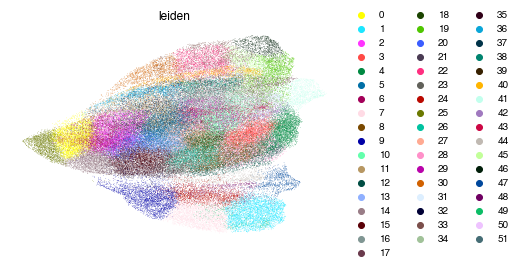

In [97]:
# sc.set_figure_params(figsize=(8, 6))
markers = ['leiden']
sc.pl.umap(adata, color=markers, frameon=False,
           ncols=1, color_map='Reds', use_raw=False,
          save='_leiden.png', )

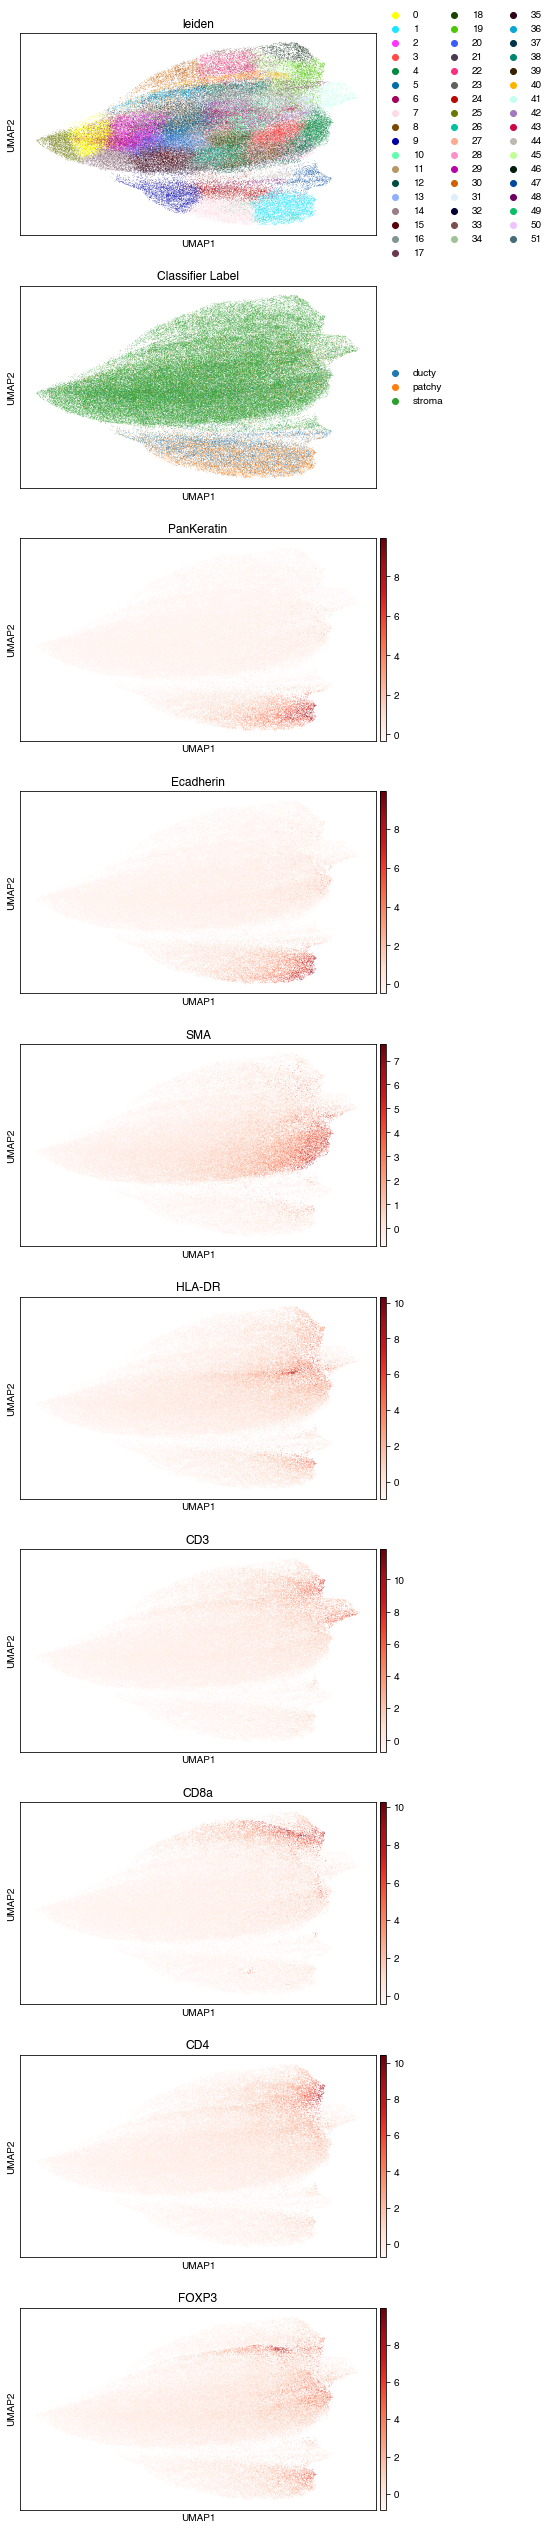

In [99]:
# sc.set_figure_params(figsize=None)
markers = ['leiden', 'Classifier Label', 'PanKeratin', 'Ecadherin', 'SMA', 'HLA-DR', 'CD3', 'CD8a', 'CD4',
          'FOXP3']
sc.pl.umap(adata, color=markers,
           ncols=1, color_map='Reds', use_raw=False)

In [ ]:
sc.pl.umap(adata, color=['sample_id', 'case_id', 'image_id'], ncols=1, color_map='Reds', use_raw=False,
          save='_image_metadata.png')

In [ ]:
sc.pl.umap(adata, color=adata.var.index, ncols=3, color_map='Reds', use_raw=False,
          save='_all_markers.png', )

In [ ]:
len(set(adata.obs['image_id']))

In [ ]:
cell_type_to_community = {}

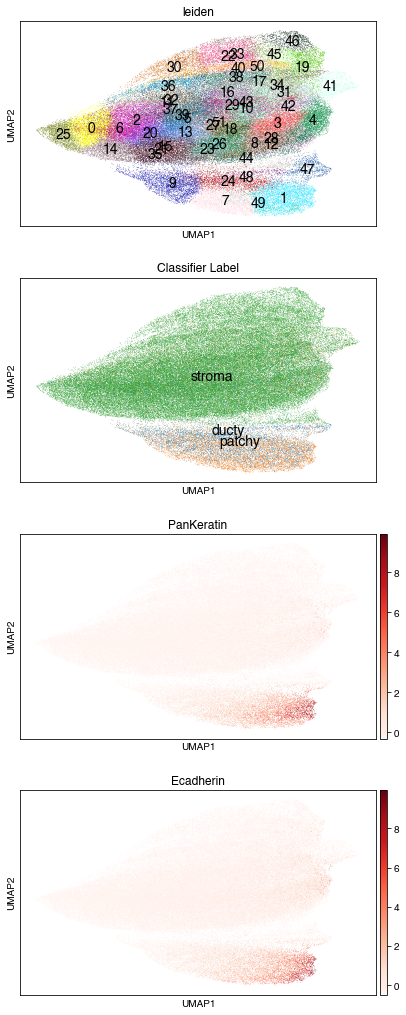

In [100]:
fontsize = 14
markers = ['leiden', 'Classifier Label', 'PanKeratin', 'Ecadherin']
sc.pl.umap(adata, color=markers, legend_loc='on data', legend_fontsize=fontsize,
           ncols=1, color_map='Reds', use_raw=False, )

In [ ]:
cell_type_to_community.update({
    'Tumor': [14, 3, 5, 28, 26, 13, 46, 23],
})

In [ ]:
# sc.set_figure_params(figsize=(8, 6))
markers = ['leiden']
sc.pl.umap(adata, color=markers, legend_loc='on data')

In [ ]:
markers = ['leiden', 'CD3', 'CD4', 'CD8a', 'FoxP3', 'Lag3', 'CD68']
sc.pl.umap(adata, color=markers, legend_loc='on data', legend_fontsize=fontsize,
           ncols=2, color_map='Reds', use_raw=False, )

In [ ]:
cell_type_to_community.update({
    'CD4_T': [19],
    'CD8_T': [32],
    'Treg': [29]
})

In [ ]:
markers = ['leiden', 'CD68', 'CD163', 'CD20', 'CD31']
sc.pl.umap(adata, color=markers, legend_loc='on data', legend_fontsize=fontsize,
           ncols=1, color_map='Reds', use_raw=False, )

In [ ]:
cell_type_to_community.update({
    'B': [17, 18, 50],
    'Macrophage': [36, 20, 41, 25, 21,16,33,12],
    'Endothelial': [4]
})

In [ ]:
markers = ['leiden', 'Vimentin', 'SMA', 'T1 Collagen']
sc.pl.umap(adata, color=markers, legend_loc='on data', legend_fontsize=fontsize,
           ncols=1, color_map='Reds', use_raw=False, )

In [ ]:
cell_type_to_community.update({
    'Fibroblast': [1, 24, 45, 8, 47, 22, 43, 30, 34, 49, 10, 2, 44],
})

In [ ]:
## name cells

community_to_cell_type = {str(c):t for t, cs in cell_type_to_community.items() for c in cs}
adata.obs['cell_type'] = [community_to_cell_type.get(c, 'unknown') for c in adata.obs['leiden']]
sc.pl.umap(adata, color=['cell_type'],  legend_fontsize=fontsize,
           ncols=1, color_map='Reds', use_raw=False, )

In [ ]:
adata.obs['cell_type']

In [ ]:
# sc.set_figure_params(figsize=(8, 5))
sns.countplot(x='sample_id', data=adata.obs, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'total_cell_count_per_sample_id.pdf'))

In [ ]:
sns.distplot(list(Counter(adata.obs['image_id']).values()), color=sns.color_palette()[0],
            bins=20, kde=False)
plt.xlabel('# of cells in ROI')
plt.ylabel('# of ROIs')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'cells_per_roi_distribution.pdf'))

In [ ]:
set(adata.obs['image_id'])

In [ ]:
# adata.uns.keys()
# adata.uns.pop('community_colors')

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'Classifier Label', 'leiden'],
           ncols=1, use_raw=False,
          save='_cell_type.png')

In [ ]:
sns.countplot(x='sample_id', data=adata.obs[adata.obs['cell_type']=='Tumor'], color=sns.color_palette()[1])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'total_tumor_cells_per_sample.pdf'))

##### calculate distance to nearest tumor cell

In [ ]:
import scipy
def closest_node(node, nodes, tree=None):
    tree = scipy.spatial.KDTree(nodes)
    return tree.query(node, k=1)
#     nodes = np.asarray(nodes)
#     dist_2 = np.sqrt(np.sum((nodes - node)**2, axis=1))
#     return np.argmin(dist_2), dist_2[np.argmin(dist_2)]

def calculate_distance_to_nearest(adata, cell_type_key='cell_type'):
    cell_types = sorted(set(adata.obs[cell_type_key]))
    image_ids = set(adata.obs['image_id'])
    cell_id_to_neighbor = {c:{} for c in adata.obs.index}
    for image_id in image_ids:
        print(image_id)
        filtered = adata[adata.obs['image_id']==image_id]
        for cell_type in cell_types:
            cells = filtered[filtered.obs[cell_type_key]==cell_type]
            xy = cells.obs[['x', 'y']].values
            if xy.shape[0]: tree = scipy.spatial.cKDTree(xy)
            
            for cell_id, x, y in zip(filtered.obs.index, filtered.obs['x'], filtered.obs['y']):
                if cells.shape[0]:
                    dist, closest = tree.query((x, y), k=1)
#                     closest, dist = closest_node(np.asarray([x, y]), xy)
#                     print(closest, dist)
                    cell_id_to_neighbor[cell_id][cell_type] = {
                        'cell_id': cells.obs.iloc[[closest]].index[0],
                        'distance': dist
                    }
                else:
                    cell_id_to_neighbor[cell_id][cell_type] = {
                        'cell_id': np.nan,
                        'distance': np.nan
                    }
    
    data = []
    cols = [[f'nearest_{ct}', f'nearest_{ct}_distance'] for ct in cell_types]
    cols = [x for xs in cols for x in xs]
    for cell_id in adata.obs.index:
        row = []
        for ct in cell_types:
            row.append(cell_id_to_neighbor[cell_id][ct]['cell_id'])
            row.append(cell_id_to_neighbor[cell_id][ct]['distance'])
        data.append(row)
            
    return pd.DataFrame(data=data, index=adata.obs.index,
                        columns=cols)
    
    return cell_id_to_neighbor
        
            
            

In [ ]:
distance_dict = calculate_distance_to_nearest(adata.copy())
distance_dict

In [ ]:
adata.obs = pd.merge(adata.obs, distance_dict, left_index=True, right_index=True)
adata.obs

In [ ]:
# distance_dict = calculate_distance_to_nearest(adata.copy(), cell_type_key='community')
# distance_dict

In [ ]:
# adata.obs = pd.merge(adata.obs, distance_dict, left_index=True, right_index=True)
# adata.obs

In [ ]:
adata

In [ ]:
# adata.obs.

In [ ]:
## save for later
adata.write_h5ad(os.path.join(run_dir, 'backup.h5ad'))

## extra analyses

In [95]:
## run this to load backup
adata = sc.read_h5ad(os.path.join(run_dir, 'backup.h5ad'))
# adata = sc.read_h5ad(os.path.join('/Volumes/timmy/ding/HTAN/imaging/analysis/htan_hyperion_b2_07282020/backup.h5ad'))
adata

AnnData object with n_obs × n_vars = 109912 × 22 
    obs: 'image_id', 'sample_id', 'case_id', 'roi', 'Classifier Label', 'Cell Area (µm²)', 'x', 'y', 'ducty_distance', 'patchy_distance', 'community', 'leiden', 'cell_type', 'nearest_B', 'nearest_B_distance', 'nearest_CD4_T', 'nearest_CD4_T_distance', 'nearest_CD8_T', 'nearest_CD8_T_distance', 'nearest_Endothelial', 'nearest_Endothelial_distance', 'nearest_Fibroblast', 'nearest_Fibroblast_distance', 'nearest_Macrophage', 'nearest_Macrophage_distance', 'nearest_Treg', 'nearest_Treg_distance', 'nearest_Tumor', 'nearest_Tumor_distance', 'nearest_unknown', 'nearest_unknown_distance', 'roi_location'
    uns: 'Classifier Label_colors', 'case_id_colors', 'cell_type_colors', 'community_colors', 'image_id_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [67]:
## run this cell if doing combined analysis

# runs = {
#     'b1': '/Volumes/timmy/ding/HTAN/imaging/analysis/htan_hyperion_b1_07302020',
#     'b2': '/Volumes/timmy/ding/HTAN/imaging/analysis/htan_hyperion_b2_07282020'
# }

# adatas = []
# genes = None
# for name, run in runs.items():
#     a = sc.read_h5ad(os.path.join(run, 'backup.h5ad'))
#     a.obs['batch'] = [name] * a.shape[0]
# #     for k in list(a.obsm.keys()): print(a.obsm[k].shape)
#     a.obsm.pop('X_pca')
#     adatas.append(a)
#     if genes is None: genes = set(a.var.index)
#     else: genes = genes.intersection(set(a.var.index))

# adatas = [a[:, sorted(genes)] for a in adatas]
# [print(a.shape, a.obsm) for a in adatas]
# adata = adatas[0].concatenate(adatas[1])

# cols = adata.obs.columns
# cols = [c.replace('_x', '') if c[-2:]=='_x' and c.replace('_x', '') not in cols else c for c in cols]
# cols = [c for c in adata.obs.columns if c[-2:] not in ['_y', '_x']]
# adata.obs = adata.obs[cols]

# adata

(66649, 20) AxisArraysView with keys: X_umap
(109912, 20) AxisArraysView with keys: X_umap


AnnData object with n_obs × n_vars = 176561 × 20 
    obs: 'Cell Area (µm²)', 'Classifier Label', 'batch', 'case_id', 'cell_type', 'community', 'ducty_distance', 'image_id', 'leiden', 'nearest_B', 'nearest_B_distance', 'nearest_CD4_T', 'nearest_CD4_T_distance', 'nearest_CD8_T', 'nearest_CD8_T_distance', 'nearest_Endothelial', 'nearest_Endothelial_distance', 'nearest_Fibroblast', 'nearest_Fibroblast_distance', 'nearest_Macrophage', 'nearest_Macrophage_distance', 'nearest_Treg', 'nearest_Treg_distance', 'nearest_Tumor', 'nearest_Tumor_distance', 'nearest_unknown', 'nearest_unknown_distance', 'patchy_distance', 'roi', 'roi_location', 'sample_id', 'tumor_distance', 'x', 'y'
    obsm: 'X_umap'

In [68]:
adata.obs

Cell Area (µm²) Classifier Label batch  \
HT055P1_PA_A1_A4_ROI_02_0-0              94.50            tumor     0   
HT055P1_PA_A1_A4_ROI_02_1-0              48.50            tumor     0   
HT055P1_PA_A1_A4_ROI_02_2-0              72.25            tumor     0   
HT055P1_PA_A1_A4_ROI_02_5-0              45.50            tumor     0   
HT055P1_PA_A1_A4_ROI_02_7-0              50.75            tumor     0   
...                                        ...              ...   ...   
HT123P1_S1H3_L1_L4_002_6003-1            80.50           stroma     1   
HT123P1_S1H3_L1_L4_002_6004-1            61.75           stroma     1   
HT123P1_S1H3_L1_L4_002_6006-1            46.00           stroma     1   
HT123P1_S1H3_L1_L4_002_6008-1            32.00           stroma     1   
HT123P1_S1H3_L1_L4_002_6009-1            66.75           stroma     1   

                               case_id   cell_type community  ducty_distance  \
HT055P1_PA_A1_A4_ROI_02_0-0    HT055P1       Tumor       NaN             NaN   
HT055P1_PA_A1_A4_ROI_02_1-0    HT055P1  Macrophage       NaN             NaN   
HT055P1_PA_A1_A4_ROI_02_2-0    HT055P1       Tumor       NaN             NaN   
HT055P1_PA_A1_A4_ROI_02_5-0    HT055P1       Tumor       NaN             NaN   
HT055P1_PA_A1_A4_ROI_02_7-0    HT055P1  Fibroblast       NaN             NaN   
...                                ...         ...       ...             ...   
HT123P1_S1H3_L1_L4_002_6003-1  HT123P1        Treg        22             NaN   
HT123P1_S1H3_L1_L4_002_6004-1  HT123P1  Macrophage         5             NaN   
HT123P1_S1H3_L1_L4_002_6006-1  HT123P1  Macrophage         8             NaN   
HT123P1_S1H3_L1_L4_002_6008-1  HT123P1  Macrophage         5             NaN   
HT123P1_S1H3_L1_L4_002_6009-1  HT123P1     unknown         8             NaN   

                                              image_id leiden  \
HT055P1_PA_A1_A4_ROI_02_0-0    HT055P1_PA_A1_A4_ROI_02     13   
HT055P1_PA_A1_A4_ROI_02_1-0    HT055P1_PA_A1_A4_ROI_02     12   
HT055P1_PA_A1_A4_ROI_02_2-0    HT055P1_PA_A1_A4_ROI_02     13   
HT055P1_PA_A1_A4_ROI_02_5-0    HT055P1_PA_A1_A4_ROI_02      3   
HT055P1_PA_A1_A4_ROI_02_7-0    HT055P1_PA_A1_A4_ROI_02     22   
...                                                ...    ...   
HT123P1_S1H3_L1_L4_002_6003-1   HT123P1_S1H3_L1_L4_002     40   
HT123P1_S1H3_L1_L4_002_6004-1   HT123P1_S1H3_L1_L4_002     31   
HT123P1_S1H3_L1_L4_002_6006-1   HT123P1_S1H3_L1_L4_002     16   
HT123P1_S1H3_L1_L4_002_6008-1   HT123P1_S1H3_L1_L4_002     31   
HT123P1_S1H3_L1_L4_002_6009-1   HT123P1_S1H3_L1_L4_002     15   

                                                  nearest_B  ...  \
HT055P1_PA_A1_A4_ROI_02_0-0     HT055P1_PA_A1_A4_ROI_02_245  ...   
HT055P1_PA_A1_A4_ROI_02_1-0    HT055P1_PA_A1_A4_ROI_02_1346  ...   
HT055P1_PA_A1_A4_ROI_02_2-0    HT055P1_PA_A1_A4_ROI_02_1346  ...   
HT055P1_PA_A1_A4_ROI_02_5-0    HT055P1_PA_A1_A4_ROI_02_1346  ...   
HT055P1_PA_A1_A4_ROI_02_7-0    HT055P1_PA_A1_A4_ROI_02_1346  ...   
...                                                     ...  ...   
HT123P1_S1H3_L1_L4_002_6003-1                           nan  ...   
HT123P1_S1H3_L1_L4_002_6004-1                           nan  ...   
HT123P1_S1H3_L1_L4_002_6006-1                           nan  ...   
HT123P1_S1H3_L1_L4_002_6008-1                           nan  ...   
HT123P1_S1H3_L1_L4_002_6009-1                           nan  ...   

                               nearest_Tumor_distance  \
HT055P1_PA_A1_A4_ROI_02_0-0                  0.000000   
HT055P1_PA_A1_A4_ROI_02_1-0                 11.597414   
HT055P1_PA_A1_A4_ROI_02_2-0                  0.000000   
HT055P1_PA_A1_A4_ROI_02_5-0                  0.000000   
HT055P1_PA_A1_A4_ROI_02_7-0                  8.200610   
...                                               ...   
HT123P1_S1H3_L1_L4_002_6003-1              317.616120   
HT123P1_S1H3_L1_L4_002_6004-1              183.360983   
HT123P1_S1H3_L1_L4_002_6006-1              275.136784   
HT123P1_S1H3_L1_L4_002_60

###### roi visualization

In [39]:
sorted(set(adata.obs['image_id']))

['HT055P1_PA_A1_A4_ROI_02',
 'HT055P1_PA_A1_A4_ROI_03',
 'HT055P1_PA_A1_A4_ROI_04',
 'HT055P1_PA_A1_A4_ROI_05',
 'HT056P1_PB_A1_A4_ROI_01',
 'HT056P1_PB_A1_A4_ROI_02',
 'HT056P1_PB_A1_A4_ROI_03',
 'HT056P1_PB_A1_A4_ROI_04',
 'HT056P1_PB_A1_A4_ROI_05',
 'HT060P1_PA_A1_A4_ROI_01',
 'HT060P1_PA_A1_A4_ROI_02',
 'HT060P1_PB_A1_A4_ROI_01',
 'HT060P1_PB_A1_A4_ROI_02',
 'HT060P1_PB_A1_A4_ROI_04',
 'HT060P1_PB_A1_A4_ROI_05',
 'HT060P1_PB_A1_A4_ROI_06',
 'HT060P1_REMAIN_ROI_02',
 'HT060P1_REMAIN_ROI_03',
 'HT060P1_REMAIN_ROI_04',
 'HT061P1_PA_A1_A4_ROI_01',
 'HT061P1_PA_A1_A4_ROI_02',
 'HT061P1_PA_A1_A4_ROI_03',
 'HT061P1_PB_A1_A4_ROI_01',
 'HT061P1_PB_A1_A4_ROI_02',
 'HT061P1_PB_A1_A4_ROI_03',
 'HT061P1_PC_A1_A4_ROI_01',
 'HT062B1_PA_ROI_01',
 'HT062B1_PA_ROI_02',
 'HT062B1_PA_ROI_03',
 'HT062B1_PB_A1_A4_ROI_01',
 'HT062B1_PB_A1_A4_ROI_02',
 'HT064B1_H1_A1_A4_ROI_01',
 'HT064B1_H1_A1_A4_ROI_03',
 'HT064B1_H1_A1_A4_ROI_04',
 'HT064B1_H7_A1_A4_ROI_01',
 'HT064B1_H7_A1_A4_ROI_02',
 'HT064B1_H7_A1_

In [40]:
# adata.obs[adata.obs['image_id']=='HT061P1_PA_A1_A4_ROI_03']

In [41]:
# image_id = 'HT123P1_S1H1_L1_L4_001'
image_id = 'HT061P1_PA_A1_A4_ROI_03'
# filtered = adata[adata.obs['image_id']=='human_spleen_HT093_ROI_01'].copy()
filtered = adata[adata.obs['image_id']==image_id].copy()
# filtered = adata[adata.obs['image_id']=='HT056P1_PB_A1_A4_ROI_04'].copy()
filtered

AnnData object with n_obs × n_vars = 2335 × 20 
    obs: 'Cell Area (µm²)', 'Classifier Label', 'batch', 'case_id', 'cell_type', 'community', 'ducty_distance', 'image_id', 'leiden', 'nearest_B', 'nearest_B_distance', 'nearest_CD4_T', 'nearest_CD4_T_distance', 'nearest_CD8_T', 'nearest_CD8_T_distance', 'nearest_Endothelial', 'nearest_Endothelial_distance', 'nearest_Fibroblast', 'nearest_Fibroblast_distance', 'nearest_Macrophage', 'nearest_Macrophage_distance', 'nearest_Treg', 'nearest_Treg_distance', 'nearest_Tumor', 'nearest_Tumor_distance', 'nearest_unknown', 'nearest_unknown_distance', 'patchy_distance', 'roi', 'roi_location', 'sample_id', 'tumor_distance', 'x', 'y'
    obsm: 'X_umap'

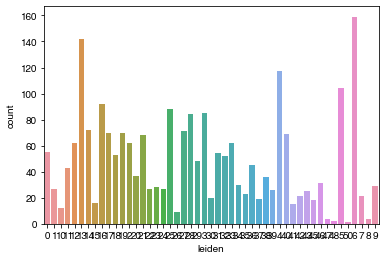

In [42]:
# sc.set_figure_params(figsize=(6, 4))
sns.countplot(x='leiden', data=filtered.obs)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

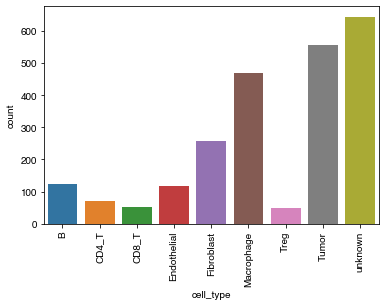

In [43]:
sns.countplot(x='cell_type', data=filtered.obs)
plt.xticks(rotation=90)

In [44]:

# ax = sc.pl.dotplot(adata, markers, groupby='cell_type', dendrogram=True, log=True)

In [45]:
filtered.obs

Cell Area (µm²) Classifier Label batch  \
HT061P1_PA_A1_A4_ROI_03_2-0               50.00            tumor     0   
HT061P1_PA_A1_A4_ROI_03_3-0               40.00            tumor     0   
HT061P1_PA_A1_A4_ROI_03_4-0               48.00            tumor     0   
HT061P1_PA_A1_A4_ROI_03_5-0               48.75            tumor     0   
HT061P1_PA_A1_A4_ROI_03_6-0               61.50            tumor     0   
...                                         ...              ...   ...   
HT061P1_PA_A1_A4_ROI_03_3888-0            60.50           stroma     0   
HT061P1_PA_A1_A4_ROI_03_3889-0            69.00           stroma     0   
HT061P1_PA_A1_A4_ROI_03_3891-0            54.25           stroma     0   
HT061P1_PA_A1_A4_ROI_03_3892-0            47.25           stroma     0   
HT061P1_PA_A1_A4_ROI_03_3893-0            74.25           stroma     0   

                                case_id    cell_type community  \
HT061P1_PA_A1_A4_ROI_03_2-0     HT061P1        Tumor       NaN   
HT061P1_PA_A1_A4_ROI_03_3-0     HT061P1        Tumor       NaN   
HT061P1_PA_A1_A4_ROI_03_4-0     HT061P1   Fibroblast       NaN   
HT061P1_PA_A1_A4_ROI_03_5-0     HT061P1   Fibroblast       NaN   
HT061P1_PA_A1_A4_ROI_03_6-0     HT061P1        CD8_T       NaN   
...                                 ...          ...       ...   
HT061P1_PA_A1_A4_ROI_03_3888-0  HT061P1   Macrophage       NaN   
HT061P1_PA_A1_A4_ROI_03_3889-0  HT061P1   Macrophage       NaN   
HT061P1_PA_A1_A4_ROI_03_3891-0  HT061P1            B       NaN   
HT061P1_PA_A1_A4_ROI_03_3892-0  HT061P1  Endothelial       NaN   
HT061P1_PA_A1_A4_ROI_03_3893-0  HT061P1            B       NaN   

                                ducty_distance                 image_id  \
HT061P1_PA_A1_A4_ROI_03_2-0                NaN  HT061P1_PA_A1_A4_ROI_03   
HT061P1_PA_A1_A4_ROI_03_3-0                NaN  HT061P1_PA_A1_A4_ROI_03   
HT061P1_PA_A1_A4_ROI_03_4-0                NaN  HT061P1_PA_A1_A4_ROI_03   
HT061P1_PA_A1_A4_ROI_03_5-0                NaN  HT061P1_PA_A1_A4_ROI_03   
HT061P1_PA_A1_A4_ROI_03_6-0                NaN  HT061P1_PA_A1_A4_ROI_03   
...                                        ...                      ...   
HT061P1_PA_A1_A4_ROI_03_3888-0             NaN  HT061P1_PA_A1_A4_ROI_03   
HT061P1_PA_A1_A4_ROI_03_3889-0             NaN  HT061P1_PA_A1_A4_ROI_03   
HT061P1_PA_A1_A4_ROI_03_3891-0             NaN  HT061P1_PA_A1_A4_ROI_03   
HT061P1_PA_A1_A4_ROI_03_3892-0             NaN  HT061P1_PA_A1_A4_ROI_03   
HT061P1_PA_A1_A4_ROI_03_3893-0             NaN  HT061P1_PA_A1_A4_ROI_03   

                               leiden                     nearest_B  ...  \
HT061P1_PA_A1_A4_ROI_03_2-0        23   HT061P1_PA_A1_A4_ROI_03_201  ...   
HT061P1_PA_A1_A4_ROI_03_3-0        23   HT061P1_PA_A1_A4_ROI_03_201  ...   
HT061P1_PA_A1_A4_ROI_03_4-0         2  HT061P1_PA_A1_A4_ROI_03_2082  ...   
HT061P1_PA_A1_A4_ROI_03_5-0        10  HT061P1_PA_A1_A4_ROI_03_2082  ...   
HT061P1_PA_A1_A4_ROI_03_6-0        32  HT061P1_PA_A1_A4_ROI_03_2082  ...   
...                               ...                           ...  ...   
HT061P1_PA_A1_A4_ROI_03_3888-0     21  HT061P1_PA_A1_A4_ROI_03_1942  ...   
HT061P1_PA_A1_A4_ROI_03_3889-0     25  HT061P1_PA_A1_A4_ROI_03_3893  ...   
HT061P1_PA_A1_A4_ROI_03_3891-0     18  HT061P1_PA_A1_A4_ROI_03_3891  ...   
HT061P1_PA_A1_A4_ROI_03_3892-0      4  HT061P1_PA_A1_A4_ROI_03_1942  ...   
HT061P1_PA_A1_A4_ROI_03_3893-0     17  HT061P1_PA_A1_A4_ROI_03_3893  ...   

                                nearest_Tumor_distance  \
HT061P1_PA_A1_A4_ROI_03_2-0                   0.000000   
HT061P1_PA_A1_A4_ROI_03_3-0                   0.000000   
HT061P1_PA_A1_A4_ROI_03_4-0                   9.708244   
HT061P1_PA_A1_A4_ROI_03_5-0                   8.139410   
HT061P1_PA_A1_A4_ROI_03_6-0                  25.553865   
...                                                ...   
HT061P1_PA_A1_A4_ROI_03_3888-0               35.724641   
HT061P1_PA_A1_A4_ROI_03_3889-0               38.964728   
HT061P1_PA_A1_

... storing 'Classifier Label' as categorical
... storing 'case_id' as categorical
... storing 'community' as categorical
... storing 'image_id' as categorical
... storing 'leiden' as categorical
... storing 'nearest_B' as categorical
... storing 'nearest_CD4_T' as categorical
... storing 'nearest_CD8_T' as categorical
... storing 'nearest_Endothelial' as categorical
... storing 'nearest_Fibroblast' as categorical
... storing 'nearest_Macrophage' as categorical
... storing 'nearest_Treg' as categorical
... storing 'nearest_Tumor' as categorical
... storing 'nearest_unknown' as categorical
... storing 'roi_location' as categorical
... storing 'sample_id' as categorical


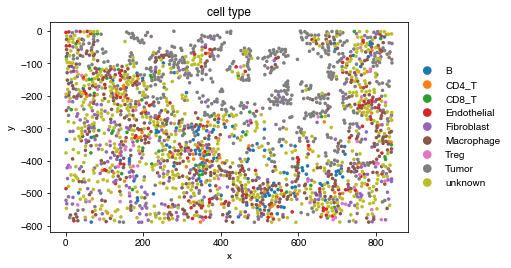

In [46]:
# fig, ax = plt.subplots(figsize=(8, 8))
# sc.set_figure_params(figsize=(10, 4))
filtered.obs['y'] = [x * -1 for x in filtered.obs['y']]
sc.pl.scatter(filtered, x='x', y='y', color='cell_type',
             save=f'{image_id}_with_cell_types.pdf')
# plt.tight_layout()
# plt.savefig(f'{image_id}_with_cell_types.pdf')

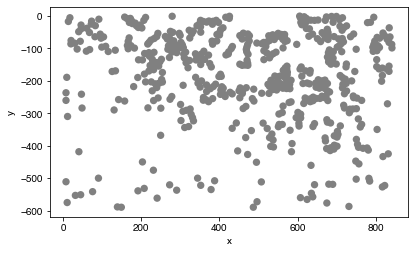

In [47]:
# fig, ax = plt.subplots(figsize=(8, 8))
mask = [True if x in ['Tumor'] else False for x in filtered.obs['cell_type']]
sc.pl.scatter(filtered[mask], x='x', y='y',
             save=f'{image_id}_with_just_tumor.pdf')


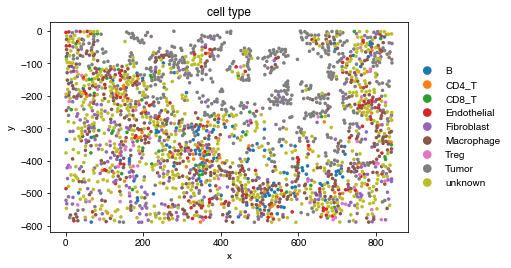

In [48]:
# fig, ax = plt.subplots(figsize=(8, 8))
mask = [True if x in ['CD4_T', 'CD8_T', 'Macrophage', 'Tumor'] else False for x in filtered.obs['cell_type']]
sc.pl.scatter(filtered, x='x', y='y', color='cell_type')

In [49]:
# sc.pl.scatter(filtered, x='X', y='Y', color='nearest_apCAF')

In [50]:
import matplotlib.patches as mpatches

In [51]:
def stacked_histogram(df, x, hue, palette=sns.color_palette(), log=False, xlim=None, ylim=None,
                     bins=None, downsample=False, figsize=(6, 1)):
    order = sorted(set(df[hue]), reverse=False)
    
    ## filter nan
    df = df[~pd.isnull(df[x])]
    
    counts = Counter(df[hue])
    
#     to_keep = [order[:i] for i in range(len(order), 0, -1)]
    to_keep = [[o] for o in order]
#     print(to_keep)
    ls = []
    for i, labels in enumerate(to_keep):
        mask = [True if value in labels else False for value in df[hue]]
        filtered = df[mask]
        if downsample:
            if len(filtered[x]) > 10:
                ls.append(np.random.choice(filtered[x], max(counts.most_common()[-1][1], 10), replace=False))
            else:
                ls.append(filtered[x])
        else:
            ls.append(filtered[x])
            
    fig, ax = plt.subplots(1, 1, figsize=figsize)
#     if bins is None: bins = int(max([x for xs in ls for x in xs]) / 2)
    ax.hist(ls,
           stacked=True, label=[str(o).split('_')[-1] for o in order], bins=bins)

    if log: ax.set_yscale('log')
    if xlim is not None: plt.xlim(xlim)
    if ylim is not None: plt.ylim(ylim)
    ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.))
    return ax

def plot_stacked_bar(df, x, hue, palette=sns.color_palette(), log=False, xlim=None, ylim=None,
                    x_order=None, hue_order=None, ax=None, b_width=1, fractions=False,
                    legend_loc='best'):
    if x_order is None: x_order = sorted(set(df[x]))
    if hue_order is None: hue_order = sorted(set(df[hue]))
    y_type = 'count' if not fractions else 'fraction'
    ps = []
    order_to_counts = {o:Counter(df[df[x]==o][hue]) for o in x_order}
    count_df_dict = {x: [], hue: [], f'{hue}_{y_type}': []}
    for o in x_order:
#         total = 0
        total = sum(order_to_counts[o][h] for h in hue_order)
        for h in hue_order:
            count_df_dict[x].append(o)
            count_df_dict[hue].append(h)
            if fractions:
                count_df_dict[f'{hue}_{y_type}'].append(order_to_counts[o][h] / total)
            else:
                count_df_dict[f'{hue}_{y_type}'].append(order_to_counts[o][h])
            
    count_df = pd.DataFrame.from_dict(count_df_dict)
    count_df = count_df.sort_values([x])
    ps = []
    for i, h in enumerate(hue_order):
        filtered = count_df[count_df[hue]==h]
        if filtered.shape[0]:
            if i == 0:
                if ax is None:
                    p = plt.bar(x_order, filtered[f'{hue}_{y_type}'], color=palette[i], width=b_width)
                else:
                    p = ax.bar(x_order, filtered[f'{hue}_{y_type}'], color=palette[i], width=b_width)
            else:
                previous_hues = hue_order[:i]
                mask = [True if prev_h in previous_hues else False for prev_h in count_df[hue]]
                previous = count_df[mask]
                previous = previous.sort_values(hue).groupby(x)[[f'{hue}_{y_type}']].sum()
                totals = previous[f'{hue}_{y_type}'].to_list()
                if ax is None:
                    p = plt.bar(x_order, filtered[f'{hue}_{y_type}'], bottom=totals, color=palette[i],
                               width=b_width)
                else:
                    p = ax.bar(x_order, filtered[f'{hue}_{y_type}'], bottom=totals, color=palette[i],
                              width=b_width)

            ps.append(p)
    if ax is None:
        plt.legend([p[0] for p in ps], hue_order, loc=legend_loc)
        plt.xticks(rotation=90)
#     else:
#         ax.legend([p[0] for p in ps], hue_order)
#         ax.set_xticks(rotation=90)

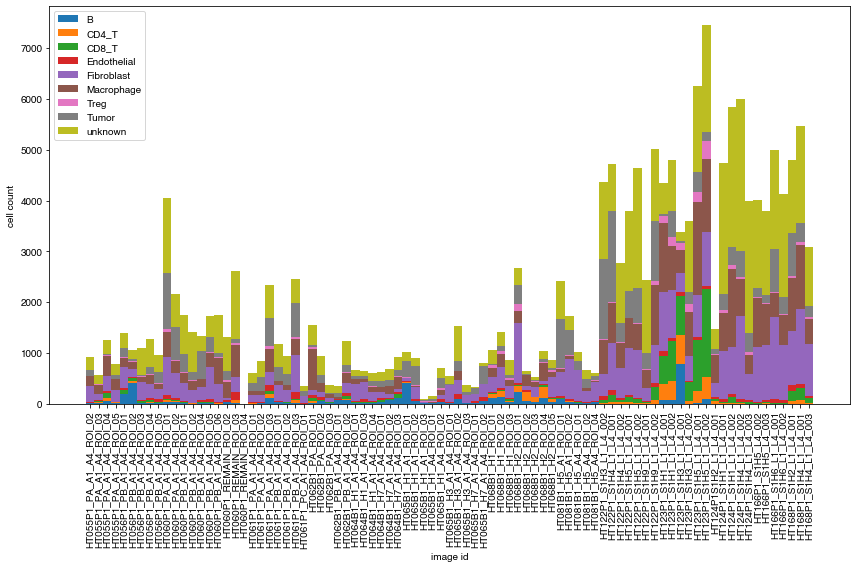

In [56]:
# sc.set_figure_params(figsize=(10, 10))
plt.figure(figsize=(12, 8))
# df = adata.obs[adata.obs['cell_type']!='Tumor']
plot_stacked_bar(adata.obs, 'image_id', 'cell_type')
plt.xlabel('image id')
plt.ylabel('cell count')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'cell_counts_for_each_roi_stacked_bar.pdf'))

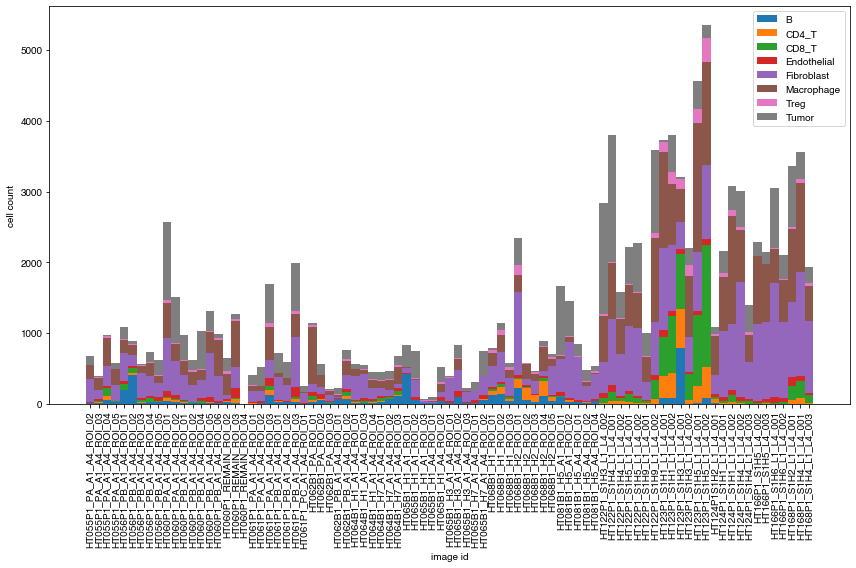

In [57]:
# sc.set_figure_params(figsize=(10, 10))
plt.figure(figsize=(12, 8))
df = adata.obs[adata.obs['cell_type']!='unknown']
plot_stacked_bar(df, 'image_id', 'cell_type')
plt.xlabel('image id')
plt.ylabel('cell count')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'cell_counts_for_each_roi_stacked_bar_no_unknown.pdf'))

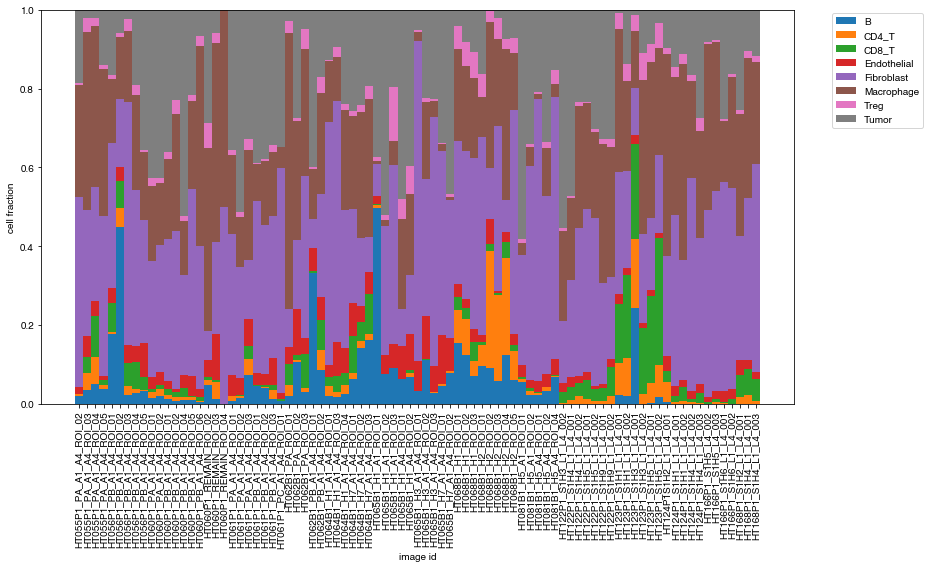

In [59]:
# sc.set_figure_params(figsize=(10, 10))
plt.figure(figsize=(13, 8))
df = adata.obs[adata.obs['cell_type']!='unknown']

plot_stacked_bar(df, 'image_id', 'cell_type', fractions=True, legend_loc=(1.05, .7))
plt.xlabel('image id')
plt.ylabel('cell fraction')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'cell_fractions_for_each_roi_stacked_bar_no_unknown.pdf'))

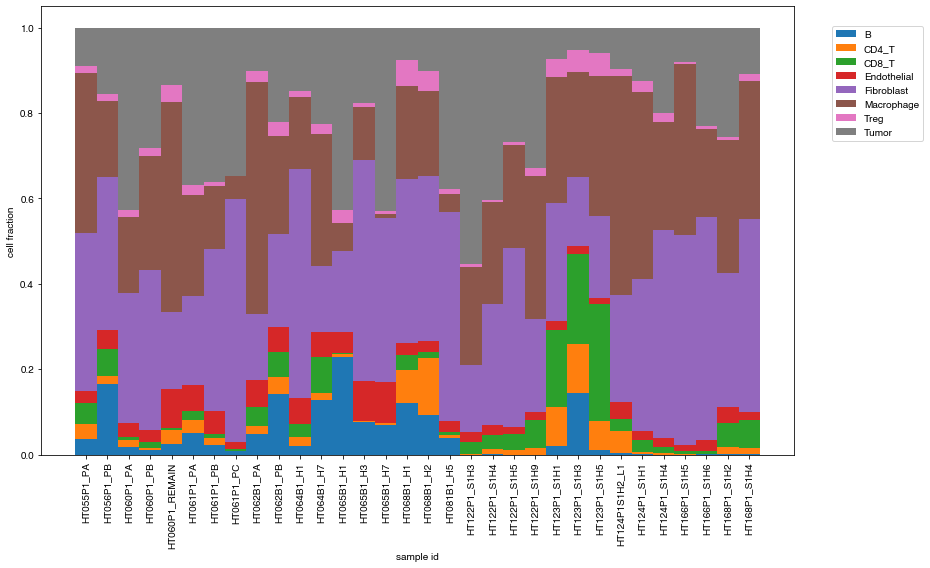

In [61]:
# sc.set_figure_params(figsize=(10, 10))
plt.figure(figsize=(13, 8))
df = adata.obs[adata.obs['cell_type']!='unknown']

plot_stacked_bar(df, 'sample_id', 'cell_type', fractions=True, legend_loc=(1.05, .7))
plt.xlabel('sample id')
plt.ylabel('cell fraction')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'cell_fractions_for_each_sample_stacked_bar_no_unknown.pdf'))

###### distance to tumor interface

In [69]:
def get_tumor_distance_from_interfaces(df, keys=['tumor_distance', 'ducty_distance', 'patchy_distance']):
    temp = df.copy()
    temp = temp[keys]
    distances = []
    for i in range(temp.shape[0]):
#         if i %100 == 50: break
        vals = temp.values[i]
        filtered = [v for v in vals if not pd.isnull(v)]
#         print(filtered)
        if filtered:
            distances.append(min(filtered))
        else:
            distances.append(np.nan)
    return np.asarray(distances)
        
adata.obs['distance'] = get_tumor_distance_from_interfaces(adata.obs)
adata.obs['distance']

HT055P1_PA_A1_A4_ROI_02_0-0       -4.7200
HT055P1_PA_A1_A4_ROI_02_1-0        0.0000
HT055P1_PA_A1_A4_ROI_02_2-0       -2.3600
HT055P1_PA_A1_A4_ROI_02_5-0       -2.3600
HT055P1_PA_A1_A4_ROI_02_7-0       -2.3600
                                   ...   
HT123P1_S1H3_L1_L4_002_6003-1    241.4893
HT123P1_S1H3_L1_L4_002_6004-1    233.5050
HT123P1_S1H3_L1_L4_002_6006-1    273.0487
HT123P1_S1H3_L1_L4_002_6008-1    396.3400
HT123P1_S1H3_L1_L4_002_6009-1    396.3400
Name: distance, Length: 176561, dtype: float64

In [70]:
Counter([(t1, t2) for t1, t2 in zip(adata.obs['cell_type'], adata.obs['Classifier Label'])]).most_common()

[(('unknown', 'stroma'), 52505),
 (('Fibroblast', 'stroma'), 33824),
 (('Macrophage', 'stroma'), 27981),
 (('Tumor', 'tumor'), 10197),
 (('CD8_T', 'stroma'), 7542),
 (('Tumor', 'patchy'), 6869),
 (('Tumor', 'ducty'), 5309),
 (('CD4_T', 'stroma'), 3697),
 (('unknown', 'tumor'), 3435),
 (('B', 'stroma'), 3172),
 (('Endothelial', 'stroma'), 3025),
 (('unknown', 'ducty'), 2821),
 (('Fibroblast', 'tumor'), 2682),
 (('Treg', 'stroma'), 2658),
 (('Tumor', 'stroma'), 1858),
 (('unknown', 'patchy'), 1570),
 (('Fibroblast', 'ducty'), 1263),
 (('Macrophage', 'patchy'), 1256),
 (('B', 'tumor'), 1102),
 (('Macrophage', 'ducty'), 970),
 (('Fibroblast', 'patchy'), 892),
 (('Macrophage', 'tumor'), 671),
 (('Endothelial', 'tumor'), 268),
 (('CD8_T', 'patchy'), 157),
 (('Endothelial', 'patchy'), 153),
 (('CD8_T', 'ducty'), 113),
 (('Treg', 'tumor'), 104),
 (('CD4_T', 'patchy'), 87),
 (('Endothelial', 'ducty'), 80),
 (('CD4_T', 'tumor'), 75),
 (('CD8_T', 'tumor'), 68),
 (('CD4_T', 'ducty'), 53),
 (('Treg

In [71]:
import matplotlib.patches as mpatches

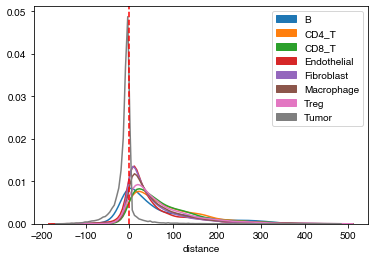

In [72]:
order = [o for o in sorted(set(adata.obs['cell_type'])) if o != 'unknown']
patches = [mpatches.Patch(color=sns.color_palette()[i], label=c)
              for i, c in enumerate(order)]
for i, cell_type in enumerate(order):
    df = adata.obs[adata.obs['cell_type']==cell_type]
#     print(cell_type, df.shape)
    sns.distplot(df['distance'], hist=False, kde=True, color=sns.color_palette()[i])
plt.axvline(0, color='red', linestyle='--')
plt.legend(handles=patches)

In [73]:
def plot_distance_to(adata, cell_type_key='cell_type', distance_key='distance', sample_id_key='sample_id',
                    ylabel_pad=50, figsize=(10, 10), log_distance=True, boundry=0):
    order = [o for o in sorted(set(adata.obs[cell_type_key]))]
    samples = [s for s in sorted(set(adata.obs[sample_id_key]))]
    fig, axs = plt.subplots(len(samples), 1, sharex=True, figsize=figsize,
                           gridspec_kw={'hspace': 0., 'wspace': .1})
    patches = [mpatches.Patch(color=sns.color_palette()[i], label=c)
                      for i, c in enumerate(order)]

    for i, s in enumerate(samples):
        ax = axs[i]
        filtered = adata[adata.obs[sample_id_key]==s]

        for i, cell_type in enumerate(order):
            df = filtered.obs[filtered.obs[cell_type_key]==cell_type]
            if log_distance:
                distribution = [np.log(x + 1) if x >= 0 else -1 * np.log(-x) for x in df[distance_key]]
            else:
                distribution = [x for x in df[distance_key]]
            sns.distplot(distribution,
                         hist=False, kde=True, color=sns.color_palette()[i],
                        ax=ax)
        ax.axvline(boundry, color='red', linestyle='--')
        ax.set_yticks([])
        ax.set_ylabel(s, labelpad=ylabel_pad, rotation=0)
    fig.add_subplot(111, frameon=False)
    plt.title('')
    # plt.xlabel('single cell expression', labelpad=50)
    # plt.ylabel('IHC marker', labelpad=50)
    plt.xticks([])
    plt.yticks([])
    if log_distance:
        plt.xlabel('log(distance)', labelpad=40)
    else:
        plt.xlabel('distance', labelpad=40)
    plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.3, 1.))

/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/mi

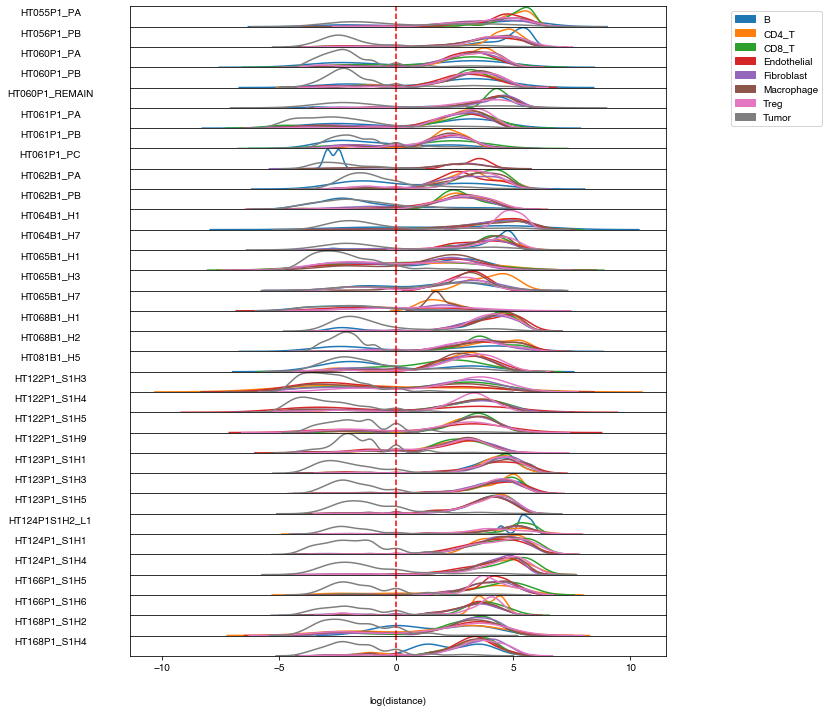

In [75]:
p_adata = adata[adata.obs['cell_type']!='unknown'].copy()
n = len(set(adata.obs['sample_id']))
plot_distance_to(p_adata, cell_type_key='cell_type', sample_id_key='sample_id', distance_key='distance',
                ylabel_pad=80, figsize=(10, int(n/3)))
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f'cell_type_to_tumor_front_distance_per_sample.pdf'))

/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/mi

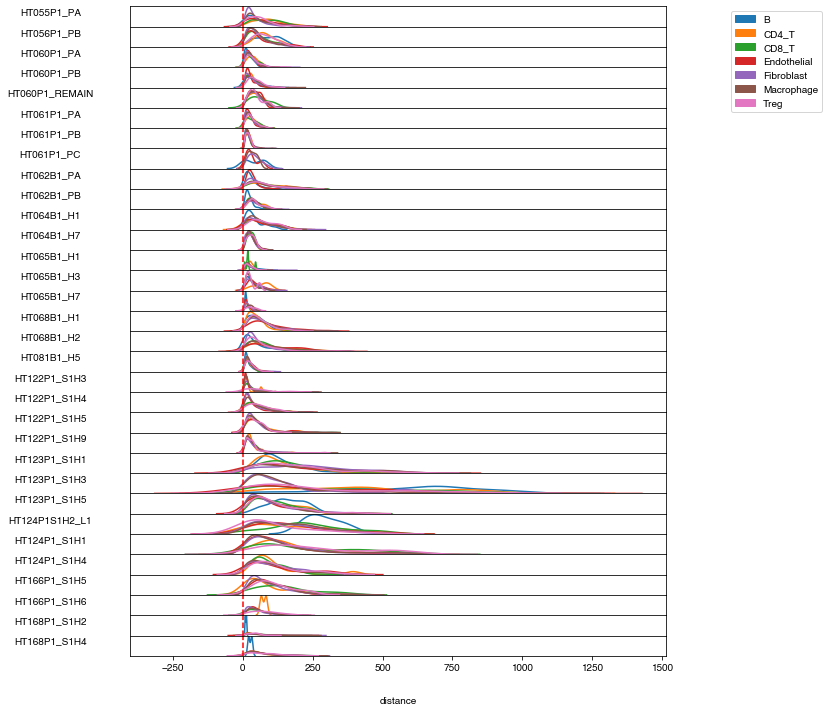

In [76]:
p_adata = adata[adata.obs['cell_type']!='unknown'].copy()
p_adata = p_adata[p_adata.obs['cell_type']!='Tumor']
n = len(set(adata.obs['sample_id']))
plot_distance_to(p_adata, cell_type_key='cell_type', sample_id_key='sample_id',
                 distance_key='nearest_Tumor_distance',
                ylabel_pad=80, figsize=(10, int(n/3)), log_distance=False)
plt.tight_layout()

plt.savefig(os.path.join(fig_dir, f'cell_type_to_nearest_tumor_per_sample_unlogged.pdf'),
           bbox_inches = "tight")

/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/mi

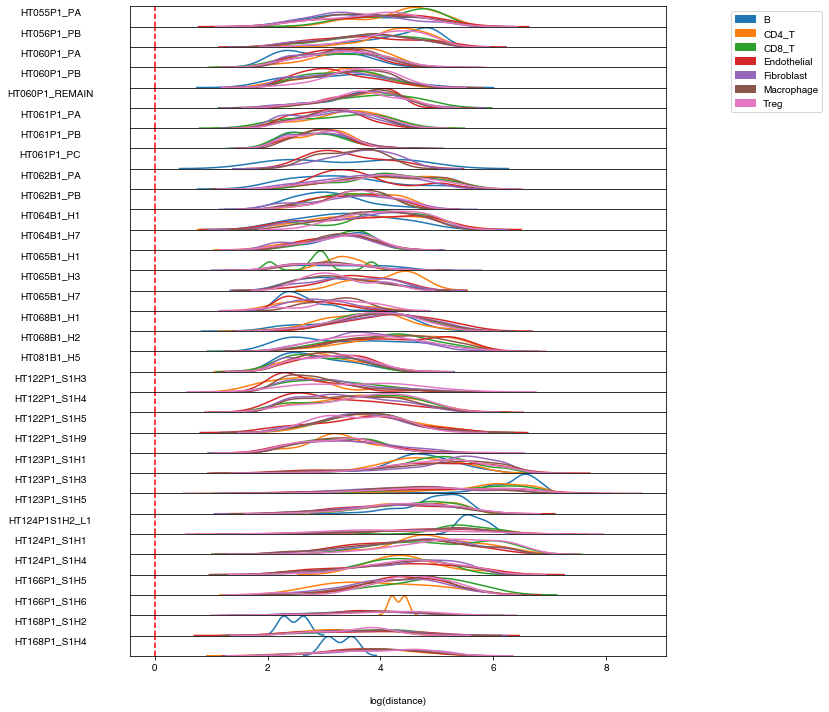

In [77]:
p_adata = adata[adata.obs['cell_type']!='unknown'].copy()
p_adata = p_adata[p_adata.obs['cell_type']!='Tumor']
n = len(set(adata.obs['sample_id']))
plot_distance_to(p_adata, cell_type_key='cell_type', sample_id_key='sample_id',
                 distance_key='nearest_Tumor_distance',
                ylabel_pad=80, figsize=(10, int(n/3)), log_distance=True)
plt.tight_layout()

plt.savefig(os.path.join(fig_dir, f'cell_type_to_nearest_tumor_per_sample_logged.pdf'),
           bbox_inches = "tight")

/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/mi

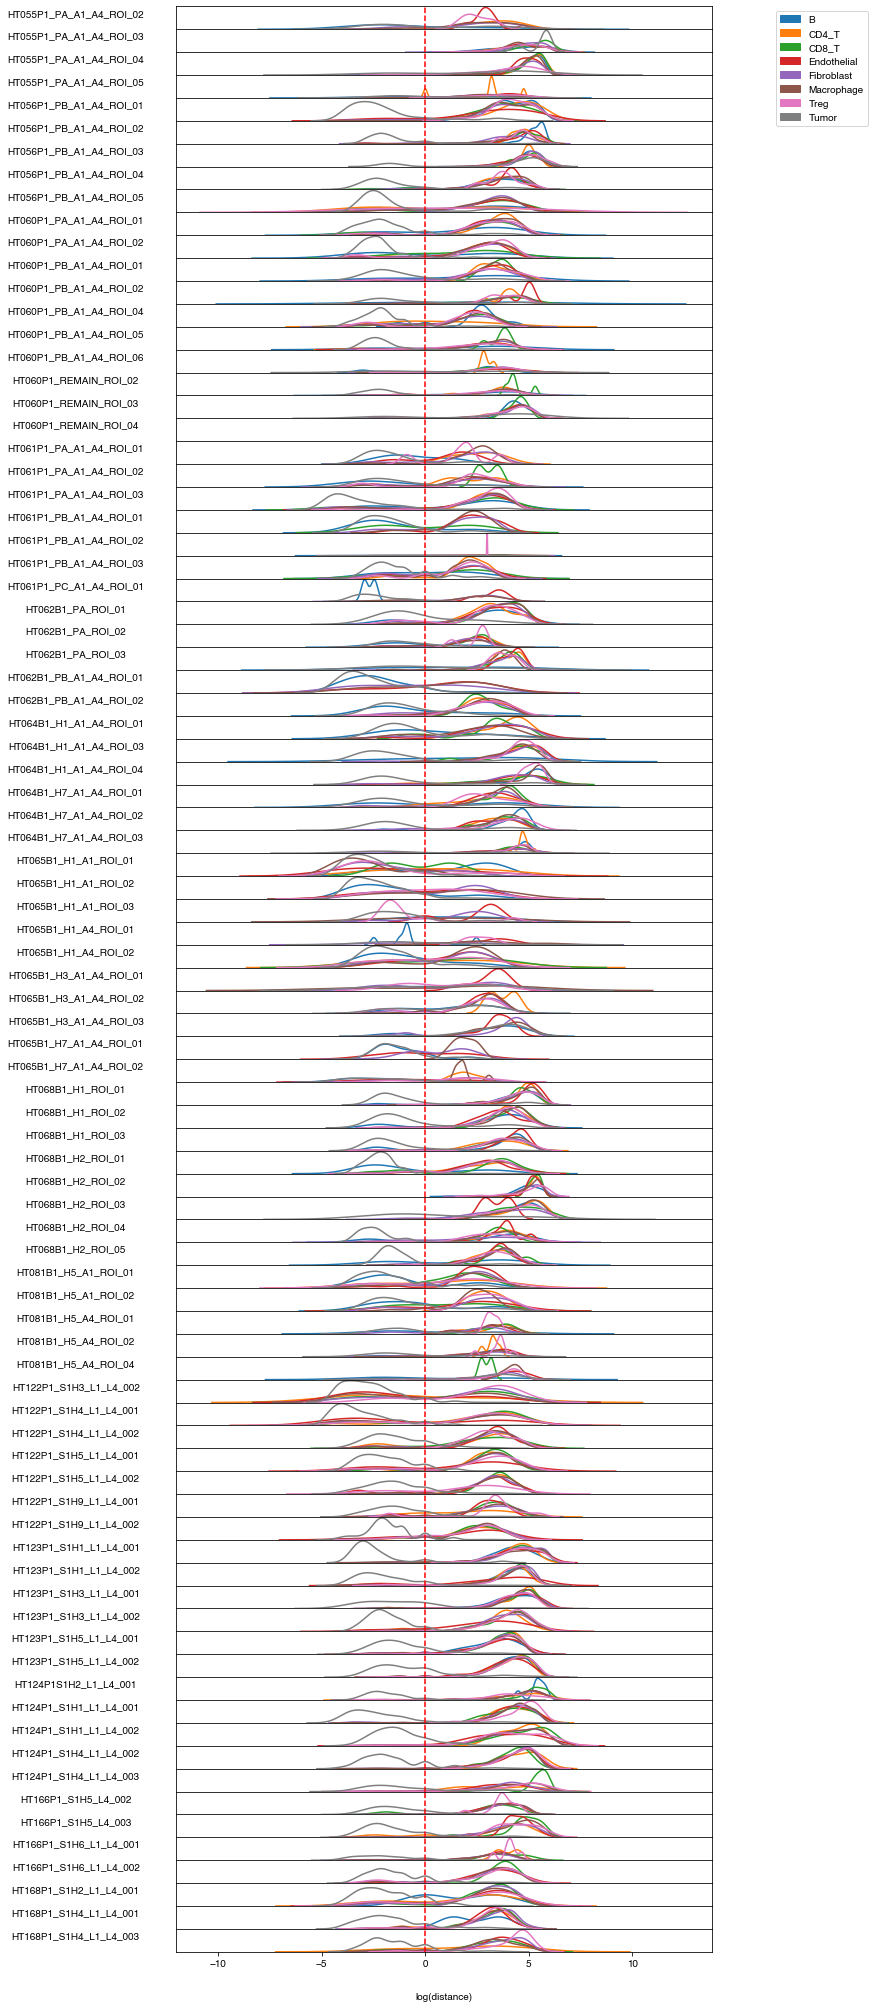

In [78]:
p_adata = adata[adata.obs['cell_type']!='unknown'].copy()
n = len(set(adata.obs['image_id']))
plot_distance_to(p_adata, cell_type_key='cell_type', sample_id_key='image_id', distance_key='distance',
                ylabel_pad=100, figsize=(10, int(n/3)))
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f'cell_type_to_tumor_front_distance_per_roi.pdf'),
           bbox_inches = "tight")

/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikstorrs/mi

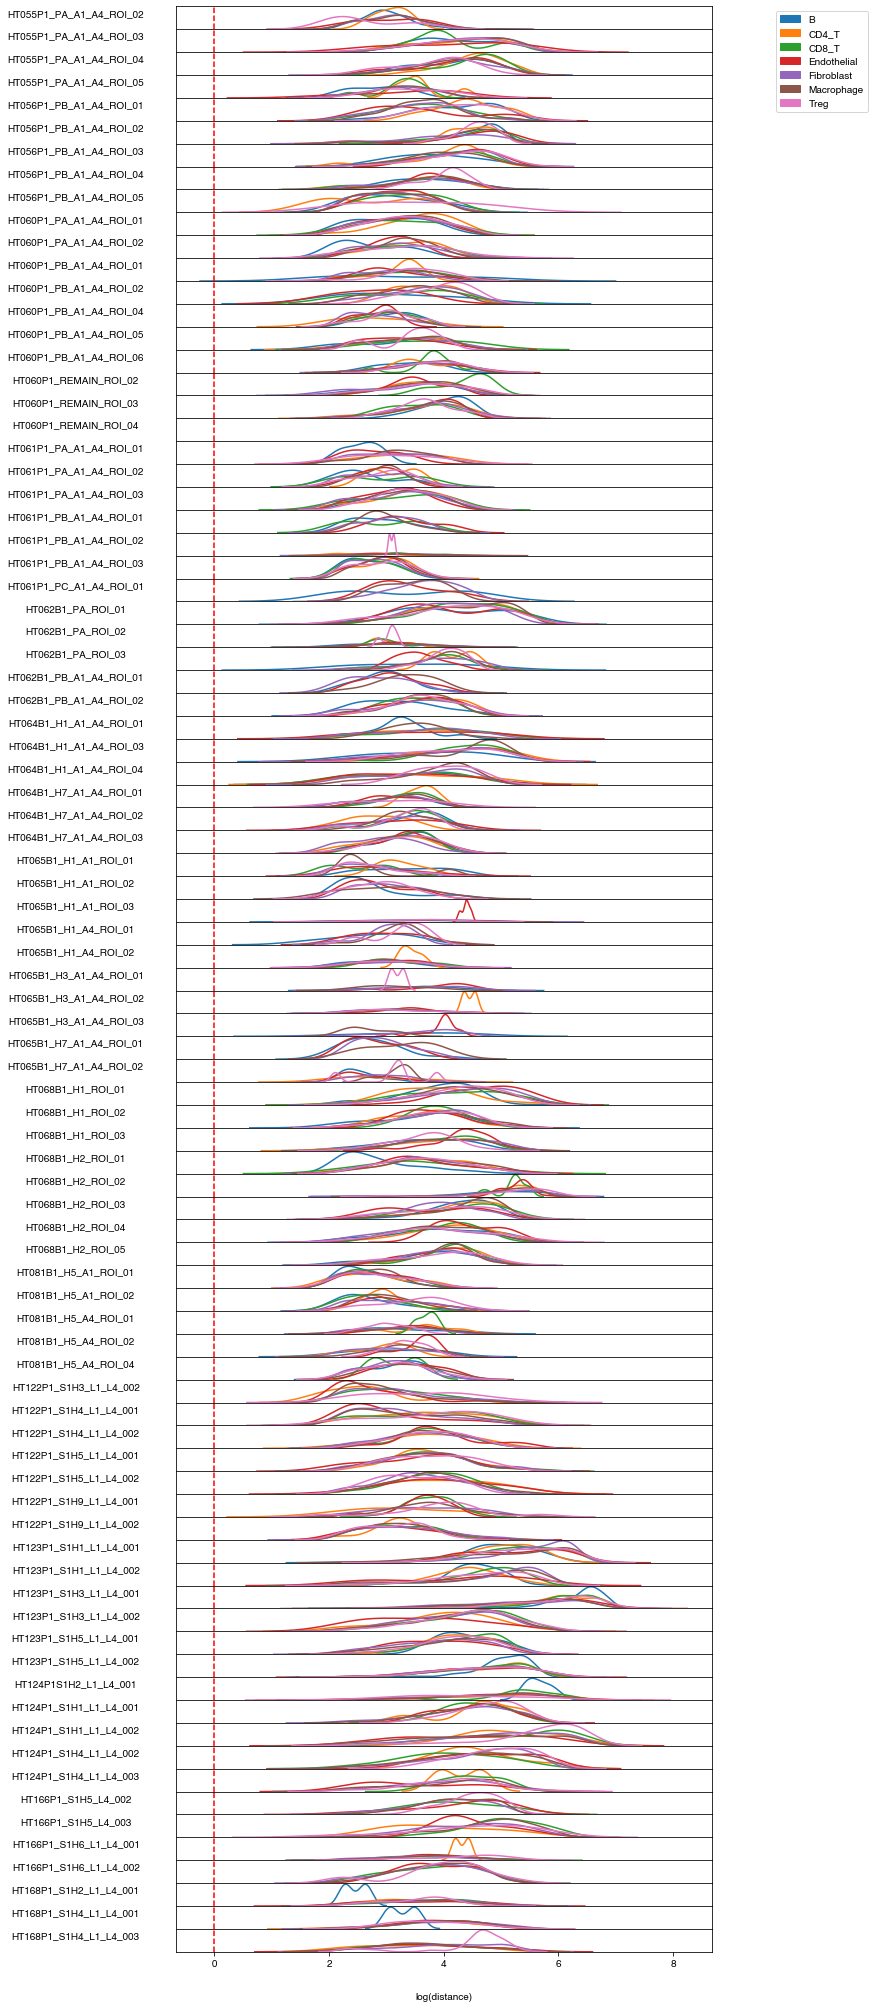

In [79]:
p_adata = adata[adata.obs['cell_type']!='unknown'].copy()
p_adata = p_adata[p_adata.obs['cell_type']!='Tumor']
plot_distance_to(p_adata, cell_type_key='cell_type', sample_id_key='image_id',
                 distance_key='nearest_Tumor_distance',
                ylabel_pad=100, figsize=(10, int(n/3)))
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f'cell_type_to_nearest_tumor_distance_per_roi.pdf'),
           bbox_inches = "tight")

In [ ]:
# p_adata = adata[adata.obs['cell_type']!='unknown'].copy()
# plot_distance_to(p_adata, cell_type_key='cell_type', sample_id_key='image_id', distance_key='patchy_distance',
#                 ylabel_pad=100, figsize=(10, 8))
# plt.tight_layout()
# plt.savefig(os.path.join(fig_dir, f'cell_type_to_tumor_front_distance_per_roi_patchy.pdf'),
#            bbox_inches = "tight")

# # p_adata = adata[adata.obs['cell_type']!='unknown'].copy()
# # plot_distance_to(p_adata, cell_type_key='cell_type', sample_id_key='image_id', distance_key='ducty_distance',
# #                 ylabel_pad=100, figsize=(10, 8))
# # plt.tight_layout()
# # plt.savefig(os.path.join(fig_dir, f'cell_type_to_tumor_front_distance_per_roi_ducty.pdf'),
# #            bbox_inches = "tight")

In [ ]:
p_adata = adata[adata.obs['cell_type']=='CD8_T'].copy()
plot_distance_to(p_adata, cell_type_key='leiden', sample_id_key='image_id', distance_key='distance',
                ylabel_pad=100, figsize=(10, 8))
plt.tight_layout()
# plt.savefig(os.path.join(fig_dir, f'cell_type_to_tumor_front_distance_per_roi.pdf'))

###### distance histogram

In [ ]:
# ## stacked histo
# import matplotlib.pyplot as plt 
# import seaborn as sns 
# tips = sns.load_dataset("tips") 
# sns.distplot(tips.total_bill, color="gold", kde=False, hist_kws={"alpha": 1}) 
# sns.distplot(tips[tips.sex == "Female"].total_bill, color="blue", kde=False, hist_kws={"alpha":1}) 
# plt.show()

In [ ]:
# temp = None
# def stacked_histogram(df, x, hue, palette=sns.color_palette(), log=False, xlim=None,
#                      bins=None):
#     order = sorted(set(df[hue]), reverse=True)
    
#     ## filter nan
#     df = df[~pd.isnull(df[x])]
    
#     to_keep = [order[:i] for i in range(len(order), 0, -1)]
#     print(to_keep)
#     for i, labels in enumerate(to_keep):
#         mask = [True if value in labels else False for value in df[hue]]
#         filtered = df[mask]
#         ax = sns.distplot(filtered[x], color=palette[i], kde=False, hist_kws={"alpha": 1}, bins=bins)
#         if xlim is not None: plt.xlim(xlim)
#         if log: ax.set_yscale('log')
#     ax.legend(np.flip(to_keep[0]))
#     return ax

def stacked_histogram(df, x, hue, palette=sns.color_palette(), log=False, xlim=None, ylim=None,
                     bins=None, downsample=False, figsize=(6, 1)):
    order = sorted(set(df[hue]), reverse=False)
    

    
    ## filter nan
    df = df[~pd.isnull(df[x])]
    
    counts = Counter(df[hue])
    
#     to_keep = [order[:i] for i in range(len(order), 0, -1)]
    to_keep = [[o] for o in order]
    print(to_keep)
    ls = []
    for i, labels in enumerate(to_keep):
        mask = [True if value in labels else False for value in df[hue]]
        filtered = df[mask]
        if downsample:
            if len(filtered[x]) > 10:
                ls.append(np.random.choice(filtered[x], max(counts.most_common()[-1][1], 10), replace=False))
            else:
                ls.append(filtered[x])
        else:
            ls.append(filtered[x])
            
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    if bins is None: bins = int(max([x for xs in ls for x in xs]) / 2)
    ax.hist(ls,
           stacked=True, label=[str(o).split('_')[-1] for o in order], bins=bins)

    if log: ax.set_yscale('log')
    if xlim is not None: plt.xlim(xlim)
    if ylim is not None: plt.ylim(ylim)
    ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.))
    return ax

In [ ]:
ax = stacked_histogram(adata[adata.obs['cell_type']!='Tumor'].obs, 'nearest_Tumor_distance', 'roi')


In [ ]:
set(adata.obs['sample_id'])

In [ ]:
set(adata.obs['case_id'])

In [ ]:
# no_tumor = adata.copy()
# mask = [False if s in exclude else True for s in [f'{x}_{y}'
#                                                   for x, y in zip(no_tumor.obs['sample_id'], no_tumor.obs['roi'])]]
# no_tumor = no_tumor[mask]

# no_tumor = no_tumor[no_tumor.obs['cell_type']!='Tumor']
# # Counter([f'{x}' for x, y, c in zip(no_tumor.obs['sample_id'], adata.obs['roi'],
# #         no_tumor.obs['cell_type']) if c == 'Fibroblast']).most_common()
# Counter([f'{x}' for x, y, c in zip(no_tumor.obs['sample_id'], adata.obs['roi'],
#         no_tumor.obs['cell_type'])]).most_common()

In [ ]:
# case = 'HT061P1'
# no_tumor = adata[adata.obs['case_id']==case]
# mask = [False if s in exclude else True for s in [f'{x}_{y}'
#                                                   for x, y in zip(no_tumor.obs['sample_id'], no_tumor.obs['roi'])]]
# no_tumor = no_tumor[mask]

# no_tumor = no_tumor[no_tumor.obs['cell_type']!='Tumor']
# Counter([f'{x}' for x, y, c in zip(no_tumor.obs['sample_id'], adata.obs['roi'],
#         no_tumor.obs['cell_type']) if c == 'Fibroblast']).most_common()

In [ ]:
tumor_counts = Counter([f'{x}_{y}' for x, y, c in zip(adata.obs['sample_id'], adata.obs['roi'],
        adata.obs['cell_type']) if c == 'Tumor'])
counts = Counter([f'{x}_{y}' for x, y, c in zip(adata.obs['sample_id'], adata.obs['roi'],
        adata.obs['cell_type'])])

In [ ]:
tumor_counts = Counter([f'{x}_{y}' for x, y, c in zip(adata.obs['sample_id'], adata.obs['roi'],
        adata.obs['cell_type']) if c == 'Tumor'])
counts = Counter([f'{x}_{y}' for x, y, c in zip(adata.obs['sample_id'], adata.obs['roi'],
        adata.obs['cell_type'])])
exclude, counts = zip(*[(s, tumor_counts[s] / counts[s])
        for s in sorted(set([f'{x}_{y}' for x, y, c in zip(adata.obs['sample_id'], adata.obs['roi'],
        adata.obs['cell_type'])])) if tumor_counts[s] / counts[s] <= .05])
exclude, counts
# [(s, count)
#         for s, count in Counter([f'{x}_{y}' for x, y, c in zip(adata.obs['sample_id'], adata.obs['roi'],
#         adata.obs['cell_type']) if c == 'Tumor']).most_common()]

In [ ]:
# case = 'HT061P1'
for case in ['HT056P1', 'HT060P1', 'HT061P1']:

# for case in ['HT056P1']:

    no_tumor = adata.copy()[adata.obs['case_id']==case]

    ## exclude low tumor

    mask = [False if s in exclude else True for s in [f'{x}_{y}'
            for x, y in zip(no_tumor.obs['sample_id'], no_tumor.obs['roi'])]]
    no_tumor = no_tumor[mask]

    no_tumor = no_tumor[no_tumor.obs['cell_type']!='Tumor']
    
    sample_ids = sorted(set(no_tumor.obs['sample_id']))
    order = [x for x in sorted(set(adata.obs['cell_type'])) if x not in ['Tumor', 'otherCAF', 'T', 'unknown']]
    
    cell_to_downsample = {}
    for cell_type in order:
        ls = []
        for sample_id in sample_ids:
            filtered = no_tumor.obs[no_tumor.obs['sample_id']==sample_id]
            filtered = filtered[filtered['cell_type']==cell_type]
            ls.append(len(filtered['nearest_Tumor_distance']))
        cell_to_downsample[cell_type] = max(min(ls), 10)
    
    for sample_id in sample_ids:
        
        filtered = no_tumor[no_tumor.obs['sample_id']==sample_id].obs
#         fig, axs = plt.subplots(len(order), 1, figsize=(10, 10))
        fig, axs = plt.subplots(len(order), 1, figsize=(10, 6),gridspec_kw={'hspace': 0, 'wspace': 0})
        print(sample_id)
        
#                                sharex='col', sharey='row',)
        for i, cell_type in enumerate(order):
            
            bins = int(max(filtered['nearest_Tumor_distance']) / 2)
            sampled = filtered[filtered['cell_type']==cell_type]['nearest_Tumor_distance']
#             if len(sampled) > cell_to_downsample[cell_type]:
#                 sampled = np.random.choice(sampled,
#                                            cell_to_downsample[cell_type], replace=False)
            
            sns.distplot(sampled, kde=False,
                              bins=bins, hist=True, color=sns.color_palette()[i], ax=axs[i]
                        )

            axs[i].set_yscale('log')
            axs[i].set_xlim((0, 200))
            axs[i].set_ylim((0, 250))
            axs[i].set_ylabel(cell_type, rotation=0, labelpad=40)
            axs[i].set_yticks([])
            if i != len(order) - 1:
                axs[i].set_xticks([])
                axs[i].set_xlabel(None)
#                 ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.))

        plt.tight_layout()
        plt.savefig(f'./figures/{sample_id}_tumor_distance.pdf')
        plt.show()
#     plt.legend(sorted(set(adata.obs['cell_type'])))

In [ ]:
# # case = 'HT061P1'
# for case in ['HT056P1', 'HT060P1', 'HT061P1']:

#     no_tumor = adata.copy()[adata.obs['case_id']==case]

#     ## exclude low tumor

#     mask = [False if s in exclude else True for s in [f'{x}_{y}'
#             for x, y in zip(no_tumor.obs['sample_id'], no_tumor.obs['roi'])]]
#     no_tumor = no_tumor[mask]

#     no_tumor = no_tumor[no_tumor.obs['cell_type']!='Tumor']



#     for cell_type in sorted(set(adata.obs['cell_type'])):
#         if cell_type != 'Tumor':
#             print(cell_type)
#             stacked_histogram(no_tumor[no_tumor.obs['cell_type']==cell_type].obs, 'nearest_Tumor_distance', 'sample_id',
#                      log=True,
#     #                  xlim=(0, max([x for x in no_tumor.obs['nearest_Tumor_distance'] if not pd.isnull(x)])),
#                      xlim=(0, 150), ylim=(0, 250),
#     #                  bins=int(max(no_tumor[no_tumor.obs['cell_type']==cell_type].obs['nearest_Tumor_distance'])/2),
#                               bins=None,
#                      downsample=True)
#             plt.tight_layout()
#             plt.savefig(f'./figures/{case}_{cell_type}_log_tumor_distance.pdf')
#             plt.show()

In [ ]:

# case = 'HT061P1'
# no_tumor = adata[adata.obs['case_id']==case]
# no_tumor = no_tumor[no_tumor.obs['cell_type']!='Tumor']
# for cell_type in sorted(set(adata.obs['cell_type'])):
#     if cell_type != 'Tumor':
#         print(cell_type)
#         for i, sample_id in enumerate(sorted(set(no_tumor.obs['sample_id']))):
#             df = no_tumor[no_tumor.obs['sample_id']==sample_id].obs
#             sns.distplot(df[df['cell_type']==cell_type]['nearest_Tumor_distance'], kde=True,
#                         color=sns.color_palette()[i], hist=True)
#             plt.xlim(0, 700)
#     #         stacked_histogram(no_tumor[no_tumor.obs['cell_type']==cell_type].obs, 'nearest_Tumor_distance', 'sample_id',
#     #                          log=True, xlim=(0, max(no_tumor.obs['nearest_Tumor_distance'])), bins=200)
#         plt.show()

In [ ]:
# mac = adata[adata.obs['cell_type']=='Macrophage']
# mac = mac[~pd.isnull(mac.obs['nearest_Tumor_distance'])]
# sns.distplot(mac[mac.obs['sample_id']=='HT061P1_PC'].obs['nearest_Tumor_distance'], kde=False)

In [ ]:
# stacked_histogram(adata.obs, 'nearest_Tumor_distance', 'roi')

In [ ]:
adata.obs['nearest_Tumor_distance']

###### distance matrix

In [ ]:
adata.obs

In [ ]:
import scipy

In [ ]:
def construct_distance_matrix(adata, cell_type_key='cell_type', metric=np.mean):
    order = sorted(set(adata.obs[cell_type_key]))
    distance_cols = [f'nearest_{cell_type}_distance' for cell_type in order]
    cols = [cell_type_key]
    cols += distance_cols
    df = adata.obs[cols]
    
    cell_type_to_distance = {ct:{} for ct in order}
    for cell_type in order:
        cell_type_df = df[df[cell_type_key]==cell_type]
        for distance_type in [c for c in distance_cols if cell_type not in c]:
            identifier = re.sub(r'^nearest_(.*)_distance$', r'\1', distance_type)
#             print(identifier)
            distances = [d for d in cell_type_df[distance_type] if not pd.isnull(d)]
            cell_type_to_distance[cell_type][identifier] = metric(distances)
    data = []
    for c1 in order:
        data.append([cell_type_to_distance[c1].get(c2, np.nan) for c2 in order])
    return pd.DataFrame(data=data, columns=order, index=order)
            
#         for cell_type_2 in order:
#             cell_type_2_df = df[df['cell_type']==cell_type_2]
            

In [ ]:
sns.countplot(x='cell_type', data=adata.obs)

In [ ]:
matrix = construct_distance_matrix(adata, cell_type_key='cell_type', metric=np.median)
sns.heatmap(matrix, cmap='Blues')
plt.ylabel('distance from')
plt.xlabel('to nearest')

In [ ]:
sc.set_figure_params(figsize=(10, 8))
matrix = construct_distance_matrix(adata, cell_type_key='cell_type', metric=np.mean)
sns.heatmap(matrix, cmap='Blues')
plt.ylabel('distance from')
plt.xlabel('to nearest')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'distance_from_cell_type_to_nearest_plot.pdf'))

In [ ]:
t = adata[adata.obs['cell_type']=='Tumor']
samples = sorted(set(t.obs['sample_id']))
patches = [mpatches.Patch(color=sns.color_palette('tab20')[i], label=c)
                  for i, c in enumerate(samples)]
for sample in samples:
    filtered = t[t.obs['sample_id']==sample]
    sns.distplot(filtered.obs['nearest_Endothelial_distance'], hist=False)
plt.legend(handles=patches)
# filtered = adata.obs['nearest_Endothelial_distance']
# filtered
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'endothelial_to_nearest_tumor_cell.pdf'))

In [ ]:
t = adata[adata.obs['cell_type']=='Tumor']
samples = sorted(set(t.obs['sample_id']))
patches = [mpatches.Patch(color=sns.color_palette('tab20')[i], label=c)
                  for i, c in enumerate(samples)]
for sample in samples:
    filtered = t[t.obs['sample_id']==sample]
    sns.distplot(filtered.obs['nearest_B_distance'], hist=False)
plt.legend(handles=patches)
# filtered = adata.obs['nearest_Endothelial_distance']
# filtered
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'bcell_to_nearest_tumor_cell.pdf'))

In [ ]:
matrix = construct_distance_matrix(adata, cell_type_key='cell_type', metric=len)
sns.heatmap(matrix, cmap='Blues')
plt.ylabel('from')
plt.xlabel('to')

In [ ]:
color_map 

In [ ]:
cell_type_specific_to_community

In [ ]:
matrix = construct_distance_matrix(adata, cell_type_key='community', metric=np.mean)
sns.heatmap(matrix, cmap='Blues')
plt.ylabel('from')
plt.xlabel('to')

In [ ]:
matrix

###### single cell correlations

###### gene expression

In [ ]:
df = pd.read_csv('/Users/erikstorrs/Downloads/HTAN_PDAC_fpkm_uq_log2+1_filtered.tsv',
                sep='\t', index_col='Gene')
df.columns = [c.replace('_S1', '_') for c in df.columns]
df.columns = [c.replace('_R1', '_REMAIN') for c in df.columns]
df = df[[c for c in sorted(set((adata.obs['sample_id']))) if c in df.columns]]
df = df.transpose()
df

In [ ]:
to_check = {
 'SMA': ['ACTA2'],
 'Vimentin': ['VIM'],
 'CD163': ['CD163'],
 'PanKeratin': ['KRT6A', 'KRT18'],
 'CD11b': ['ITGAM'],
 'PD-L1': ['CD274'],
 'CD31': ['PECAM1'],
 'CD45': ['PTPRC'],
 'Lag3': ['LAG3'],
 'FoxP3': ['FOXP3'],
 'CD4': ['CD4'],
 'Ecadherin': ['EPCAM'],
 'CD68': ['CD68'],
 'CD20': ['MS4A1'],
 'CD8a': ['CD8A'],
 'PD1': ['PDCD1'],
 'Granzyme B': ['GZMB'],
 'T1 Collagen': ['COL1A1'],
 'PD-L2': ['PDCD1LG2'],
 'CD3': ['CD3G'],
 'Ki67': ['MKI67'],
 'HLADR': ['HLA-DRA']
}
to_check = [v for k, vs in to_check.items() for v in vs]
df = df[to_check]
df

In [ ]:
# sorted(set((adata.obs['sample_id'])))

In [ ]:
# list(df.columns)

In [ ]:
import scipy

In [ ]:
samples = df.index
samples

In [ ]:
list(adata.obs.columns)

In [ ]:
intensity_df = adata.obs[['sample_id',
                          'SMA',
 'Vimentin',
 'CD163',
 'PanKeratin',
 'CD11b',
 'PD-L1',
 'CD31',
 'CD45',
 'Lag3',
 'CD11c',
 'FoxP3',
 'CD4',
 'Ecadherin',
 'CD68',
 'CD20',
 'CD8a',
 'PD1',
 'CD45RA',
 'Granzyme B',
 'T1 Collagen',
 'PD-L2',
 'CD3',
 'Ki67',
 'CD45RO',
 'HLADR']]
intensity_df = intensity_df.groupby(by='sample_id').mean()
intensity_df = intensity_df.loc[samples]
intensity_df

In [ ]:
# from sklearn.covariance import EllipticEnvelope

In [ ]:
def plot_grouped_scatter(df1, df2, mask=None, remove_outliers=False, figsize=(20, 15)):
    markers, genes = df1.columns, df2.columns
    fig, axs = plt.subplots(len(markers), len(genes),
                            figsize=figsize, gridspec_kw={'hspace': .1, 'wspace': .1})
    palette = [x for ps in [sns.color_palette('tab20'), sns.color_palette('tab20b'), sns.color_palette('tab20c')]
              for x in ps]
    for i, marker in enumerate(markers):
        for j, gene in enumerate(genes):

            ax = axs if len(markers) == 1 and len(genes) == 1 else axs[i][j]
            ax.scatter(df2[gene], df1[marker], color=palette[j])
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0: ax.set_ylabel(marker, rotation=0, labelpad=30)
            if i == len(markers)-1: ax.set_xlabel(gene, rotation=90)

            m, b = np.polyfit(df2[gene], df1[marker], 1)
            ax.plot(df2[gene], m*df2[gene] + b, '-', color='gray')
            if mask is not None and mask[i, j]:
                plt.setp(ax.spines.values(), color='red', linewidth=3)
#                 for i in ax.spines.itervalues(): [i.set_linewidth(0.1) for i in ax.spines.itervalues()]

    return fig, axs
import matplotlib.patches as mpatches
def plot_grouped_scatter_by_celltype(df1, df2, cell_types,
                                     mask=None, remove_outliers=False, figsize=(20, 15)):
    markers, genes = df1.columns, df2.columns
    fig, axs = plt.subplots(len(markers), len(genes),
                            figsize=figsize, gridspec_kw={'hspace': .1, 'wspace': .1})
    palette = [x for ps in [sns.color_palette('tab20'), sns.color_palette('tab20b'), sns.color_palette('tab20c')]
              for x in ps]
    order = sorted(set(cell_types))
    patches = [mpatches.Patch(color=palette[i], label=c)
              for i, c in enumerate(order)]

    for i, marker in enumerate(markers):
        for j, gene in enumerate(genes):
#             p_df = pd.merge(df1, df2, right_index=True, left_index=True)
#             p_df['cell_type'] = cell_types
            ax = axs if len(markers) == 1 and len(genes) == 1 else axs[i][j]
#             sns.scatterplot(y=marker, x=gene, data=p_df, hue='cell_type', ax=ax)
            ax.scatter(df2[gene], df1[marker], color=[palette[order.index(c)] for c in cell_types])
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0: ax.set_ylabel(marker, rotation=0, labelpad=30)
            if i == len(markers)-1: ax.set_xlabel(gene, rotation=90)
#             if j == len(genes) - 1 and i == len(markers) - 1:
#                 ax.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1.))

            m, b = np.polyfit(df2[gene], df1[marker], 1)
            ax.plot(df2[gene], m*df2[gene] + b, '-', color='gray')
            if mask is not None and mask[i, j]:
                plt.setp(ax.spines.values(), color='red', linewidth=3)
#                 for i in ax.spines.itervalues(): [i.set_linewidth(0.1) for i in ax.spines.itervalues()]

    return fig, axs, patches

In [ ]:
def get_correlations(df1, df2, fdr=True):

    corr_dict = {}
    for marker in df1.columns:
        corr_dict[marker] = {}
        for gene in df2.columns:
            xs, ys = zip(*[(x, y) for x, y in zip(df2[gene], df1[marker])
                          if not pd.isnull(x)
                          if not pd.isnull(y)])
            corr, pval = scipy.stats.pearsonr(xs, ys)
            corr_dict[marker][gene] = (corr, pval)
    if fdr:    
        for marker, c_dict in corr_dict.items():
            genes, vals = zip(*sorted([(k, v) for k, v in c_dict.items()],
                       key=lambda x: x[1]))
            corrs, pvals = zip(*vals)
            pvals = multitest.multipletests(pvals)[1]
            for i, gene in enumerate(genes):
                corr_dict[marker][gene] = (corrs[i], pvals[i])
    return corr_dict


In [ ]:
corr_dict = get_correlations(intensity_df, df, fdr=True)
mask = np.full((intensity_df.shape[1], df.shape[1]), False)
for i, c1 in enumerate(intensity_df.columns):
    for j, c2 in enumerate(df.columns):
        mask[i, j] = True if corr_dict[c1][c2][1] < .05 else False

fig, axs = plot_grouped_scatter(intensity_df, df, mask=mask)
fig.add_subplot(111, frameon=False)
plt.xlabel('gene expression', labelpad=50)
plt.ylabel('IHC marker', labelpad=50)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('figures/bulk_rnaseq_correlation_with_imh_imaging.pdf')

###### proteins

In [ ]:
# Counter(adata.obs[adata.obs['cell_type']=='Tumor']['image_id']).most_common()

In [ ]:
df = pd.read_csv('/Users/erikstorrs/Downloads/HTAN_PDAC_singleshot_log2_ratios-MD_norm_Formatted_NA20_Dedup_Filtered.tsv',
                sep='\t', index_col='Gene')
df.columns = [c.replace('_S1', '_') for c in df.columns]
df.columns = [c.replace('_R1', '_REMAIN') for c in df.columns]
df = df[[c for c in sorted(set((adata.obs['sample_id']))) if c in df.columns]]
df = df.transpose()
df

In [ ]:
'LAG3' in df.columns

In [ ]:
to_check = {
 'SMA': ['ACTA2'],
 'Vimentin': ['VIM'],
 'CD163': ['CD163'],
 'PanKeratin': ['KRT6A', 'KRT18'],
 'CD11b': ['ITGAM'],
 'PD-L1': ['CD274'],
 'CD31': ['PECAM1'],
 'CD45': ['PTPRC'],
 'Lag3': ['LAG3'],
 'FoxP3': ['FOXP3'],
 'CD4': ['CD4'],
 'Ecadherin': ['EPCAM'],
 'CD68': ['CD68'],
 'CD20': ['MS4A1'],
 'CD8a': ['CD8A'],
 'PD1': ['PDCD1'],
 'Granzyme B': ['GZMB'],
 'T1 Collagen': ['COL1A1'],
 'PD-L2': ['PDCD1LG2'],
 'CD3': ['CD3G'],
 'Ki67': ['MKI67'],
 'HLADR': ['HLA-DRA']
}
to_check = [v for k, vs in to_check.items() for v in vs if v in df.columns]
df = df[to_check]
df

In [ ]:
# list(adata.obs.columns)

In [ ]:
intensity_df = adata.obs[['sample_id',
                          'SMA',
 'Vimentin',
 'CD163',
 'PanKeratin',
 'CD11b',
 'PD-L1',
 'CD31',
 'CD45',
 'Lag3',
 'CD11c',
 'FoxP3',
 'CD4',
 'Ecadherin',
 'CD68',
 'CD20',
 'CD8a',
 'PD1',
 'CD45RA',
 'Granzyme B',
 'T1 Collagen',
 'PD-L2',
 'CD3',
 'Ki67',
 'CD45RO',
 'HLADR']]
intensity_df = intensity_df.groupby(by='sample_id').mean()
intensity_df = intensity_df.loc[samples]
intensity_df

In [ ]:
samples = sorted(set(df.index).intersection(set(intensity_df.index)))
df = df.loc[samples]
intensity_df = intensity_df.loc[samples]

samples

In [ ]:
corr_dict = get_correlations(intensity_df, df, fdr=True)
mask = np.full((intensity_df.shape[1], df.shape[1]), False)
for i, c1 in enumerate(intensity_df.columns):
    for j, c2 in enumerate(df.columns):
        mask[i, j] = True if corr_dict[c1][c2][1] < .05 else False

fig, axs = plot_grouped_scatter(intensity_df, df, mask=mask)
fig.add_subplot(111, frameon=False)
plt.xlabel('protein', labelpad=50)
plt.ylabel('IHC marker', labelpad=50)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('figures/protein_correlation_with_imh_imaging.pdf')

###### single cell

In [ ]:
df = pd.read_csv('/Users/erikstorrs/Downloads/Everything_merge_average_expression_orig.ident_cell_type_erik.tsv.gz',
                sep='\t')
df.columns = [c.replace('TWCE-', '') for c in df.columns]
df.columns = [re.sub(r'^(HT.+)\-S1(..).*1_(.+)$', r'\1-\2-\3', c) for c in df.columns]
df.columns = [c.replace('P-', 'P1-') for c in df.columns]
# df.columns = [c.replace('_R1', '_REMAIN') for c in df.columns]
# df = df[[c for c in sorted(set((adata.obs['sample_id']))) if c in df.columns]]
df = df.transpose()
df = df.loc[~df.index.duplicated(keep='first')]
df

In [ ]:
sorted(df.index)

In [ ]:
marker_map = {
 'SMA': ['ACTA2'],
 'Vimentin': ['VIM'],
 'CD163': ['CD163'],
 'PanKeratin': ['KRT18'],
 'CD11b': ['ITGAM'],
 'PD-L1': ['CD274'],
 'CD31': ['PECAM1'],
 'CD45': ['PTPRC'],
 'Lag3': ['LAG3'],
 'FoxP3': ['FOXP3'],
 'CD4': ['CD4'],
 'Ecadherin': ['CDH1'],
 'CD68': ['CD68'],
 'CD20': ['MS4A1'],
 'CD8a': ['CD8A'],
 'PD1': ['PDCD1'],
 'Granzyme B': ['GZMB'],
 'T1 Collagen': ['COL1A1'],
 'PD-L2': ['PDCD1LG2'],
 'CD3': ['CD3G'],
 'Ki67': ['MKI67'],
 'HLADR': ['HLA-DRA']
}
to_check = [v for k, vs in marker_map.items() for v in vs if v in df.columns]
df = df[to_check]
df

In [ ]:
def transorm_cell_type(c):
    if 'CAF' in c: return 'Fibroblast'
    return c

In [ ]:
intensity_df = adata.obs.copy()[['sample_id',
                          'cell_type',
                          'SMA',
 'Vimentin',
 'CD163',
 'PanKeratin',
 'CD11b',
 'PD-L1',
 'CD31',
 'CD45',
 'Lag3',
 'CD11c',
 'FoxP3',
 'CD4',
 'Ecadherin',
 'CD68',
 'CD20',
 'CD8a',
 'PD1',
 'CD45RA',
 'Granzyme B',
 'T1 Collagen',
 'PD-L2',
 'CD3',
 'Ki67',
 'CD45RO',
 'HLADR']]
intensity_df['sample_id'] = [s.replace('_', '-') for s in intensity_df['sample_id']]
intensity_df['sample_plus_cell_type'] = [f'{s}-{transorm_cell_type(c)}'
        for s, c in zip(intensity_df['sample_id'], intensity_df['cell_type'])]
intensity_df = intensity_df.groupby(by='sample_plus_cell_type').mean()
intensity_df

In [ ]:
sorted(df.index)

In [ ]:
[c for c in intensity_df.index if 'HT061' in c], [c for c in df.index if 'HT061' in c]

In [ ]:
samples = sorted(set(df.index).intersection(set(intensity_df.index)))
df = df.loc[samples]
intensity_df = intensity_df.loc[samples]

samples

In [ ]:
df.shape, intensity_df.shape

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
corr_dict = get_correlations(intensity_df, df, fdr=True)
mask = np.full((intensity_df.shape[1], df.shape[1]), False)
for i, c1 in enumerate(intensity_df.columns):
    for j, c2 in enumerate(df.columns):
        mask[i, j] = True if corr_dict[c1][c2][1] < .05 else False

fig, axs = plot_grouped_scatter(intensity_df, df, mask=mask, remove_outliers=False)
fig.add_subplot(111, frameon=False)
plt.xlabel('single cell expression', labelpad=50)
plt.ylabel('IHC marker', labelpad=50)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('figures/single_cell_correlation_with_imh_imaging.pdf')

In [ ]:
# cell_types = sorted(set([c.split('-')[-1] for c in intensity_df.index]))
# for cell_type in cell_types:
#     print(cell_type)
#     df1 = intensity_df.loc[[x for x in intensity_df.index if cell_type in x.split('-')[-1]]]
#     df2 = df.loc[[x for x in df.index if cell_type in x.split('-')[-1]]]
#     corr_dict = get_correlations(df1, df2, fdr=True)
#     mask = np.full((df1.shape[1], df2.shape[1]), False)
#     for i, c1 in enumerate(df1.columns):
#         for j, c2 in enumerate(df2.columns):
#             mask[i, j] = True if corr_dict[c1][c2][1] < .05 else False

#     fig, axs = plot_grouped_scatter(df1, df2, mask=mask, remove_outliers=False)
#     fig.add_subplot(111, frameon=False)
#     plt.xlabel('single cell expression', labelpad=50)
#     plt.ylabel('IHC marker', labelpad=50)
#     plt.xticks([])
#     plt.yticks([])
#     plt.tight_layout()
#     plt.show()


In [ ]:
sorted(set(adata.obs['cell_type']))

In [ ]:
cell_to_markers = {
    'B': {
        'IHC': ['CD20'],
        'expression': ['MS4A1']
    },
    'CD4_T': {
        'IHC': ['CD3', 'CD4'],
        'expression': ['CD3G', 'CD4']
    },
    'CD_8': {
        'IHC': ['CD8a', 'Granzyme B'],
        'expression': ['CD3G', 'CD8A', 'GZMB']
    },
    'Endothelial': {
        'IHC': ['CD31'],
        'expression': ['PECAM1']
    },
    'Macrophage': {
        'IHC': ['CD11b', 'CD68', 'CD163'],
        'expression': ['ITGAM', 'CD68', 'CD163']
    },
    'T': {
        'IHC': ['CD3'],
        'expression': ['CD3G']
    },
    'Treg': {
        'IHC': ['FoxP3'],
        'expression': ['FOXP3']
    },
    'Tumor': {
        'IHC': ['PanKeratin', 'Ecadherin'],
        'expression': ['KRT18', 'CDH1']
    },
    'Fibroblast': {
        'IHC': ['SMA', 'Vimentin', 'T1 Collagen', 'HLADR'],
        'expression': ['ACTA2', 'HLA-DRA', 'VIM', 'COL1A1']
    },
}

In [ ]:
for cell_type, d in cell_to_markers.items():
    print(cell_type)
    df1 = intensity_df[d['IHC']]
    df2 = df[d['expression']]
    
    mask = np.full((df1.shape[1], df2.shape[1]), False)
    for i, c1 in enumerate(df1.columns):
        for j, c2 in enumerate(df2.columns):
            mask[i, j] = True if corr_dict[c1][c2][1] < .05 else False
            
            
    fig, axs, patches = plot_grouped_scatter_by_celltype(df1, df2, [x.split('-')[-1] for x in df1.index],
                                                mask=mask, remove_outliers=False, figsize=(10, 6))
    fig.add_subplot(111, frameon=False)
    plt.title(cell_type)
    plt.xlabel('single cell expression', labelpad=50)
    plt.ylabel('IHC marker', labelpad=50)
    plt.xticks([])
    plt.yticks([])
    plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1.))
    plt.tight_layout()
    plt.savefig(f'figures/single_cell_correlation_with_imh_imaging_{cell_type}.pdf')
    plt.show()

In [ ]:
cell_to_markers = {
    'B': {
        'IHC': ['CD20'],
        'expression': ['MS4A1']
    },
    'CD4_T': {
        'IHC': ['CD4'],
        'expression': ['CD4']
    },
    'CD8_T': {
        'IHC': ['CD8a'],
        'expression': ['CD8A']
    },
    'Endothelial': {
        'IHC': ['CD31'],
        'expression': ['PECAM1']
    },
    'Macrophage': {
        'IHC': ['CD68'],
        'expression': ['CD68']
    },
    'Treg': {
        'IHC': ['FoxP3'],
        'expression': ['FOXP3']
    },
    'Tumor': {
        'IHC': ['PanKeratin'],
        'expression': ['KRT18']
    },
    'Fibroblast': {
        'IHC': ['SMA'],
        'expression': ['ACTA2']
    },
}

In [ ]:
# intensity_df

In [ ]:
for cell_type, d in cell_to_markers.items():
    print(cell_type)
    df1 = intensity_df.copy()[d['IHC']]
    df2 = df[d['expression']]
    
#     mask = np.full((df1.shape[1], df2.shape[1]), False)
#     for i, c1 in enumerate(df1.columns):
#         for j, c2 in enumerate(df2.columns):
#             mask[i, j] = True if corr_dict[c1][c2][1] < .05 else False
    
    mask = [True if cell_type in c.split('-')[-1] else False for c in df1.index]
    df1 = df1[mask]
    df2 = df2[mask]
    
    print(df1.shape, df2.shape)
            
    fig, axs, patches = plot_grouped_scatter_by_celltype(df1, df2, [x.split('-')[-1] for x in df1.index],
                                                mask=None, remove_outliers=False, figsize=(10, 6))
    fig.add_subplot(111, frameon=False)
    plt.title(cell_type)
    plt.xlabel('single cell expression', labelpad=50)
    plt.ylabel('IHC marker', labelpad=50)
    plt.xticks([])
    plt.yticks([])
    plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1.))
    plt.tight_layout()
    plt.savefig(f'figures/formatted_single_cell_correlation_with_imh_imaging_{cell_type}.pdf')
    plt.show()

##### patchy ducty

In [ ]:
# patchy = process_halo_object_data(pd.read_csv(
#     '/Volumes/timmy/ding/HTAN/imaging/data/halo_outputs/Halo archive 2020-07-27 16-05 - v3.1.1076_b2/object_results.csv',
#     sep=','))

In [ ]:
df = pd.read_csv('/Volumes/timmy/ding/HTAN/imaging/data/halo_outputs/Halo archive 2020-07-27 21-17 - v3.1.1076_b2/summary_results.csv')
df

In [ ]:
df = df[['Image Tag', 'patchy Area (mm²)', 'ducty Area (mm²)', 'stroma Area (mm²)']]
df['image_id'] = [x.replace('L1_', '').replace('L4_', '').replace('.ome.tiff', '') for x in df['Image Tag']]
df

In [ ]:
df['patchy_ratio'] = df['patchy Area (mm²)'] / df['ducty Area (mm²)']

In [ ]:
order = sorted(df['Image Tag'])
sns.barplot(x='Image Tag', y='patchy_ratio', data=df, order=order)
plt.xticks(rotation=90)

In [ ]:
width = .8
df = df.sort_values('Image Tag')
p1 = plt.bar(df['Image Tag'], df['patchy Area (mm²)'].to_list(), width)
p2 = plt.bar(df['Image Tag'], df['ducty Area (mm²)'].to_list(), width,
             bottom=df['patchy Area (mm²)'].to_list(),)

plt.xticks(rotation=90)

In [ ]:
width = .8
df['sample'] = ['_'.join(x.split('_')[:1]) for x in df['image_id']]
df['patchy_component'] = df['patchy Area (mm²)'] / (df['patchy Area (mm²)'] + df['ducty Area (mm²)'])
df['ducty_component'] = df['ducty Area (mm²)'] / (df['patchy Area (mm²)'] + df['ducty Area (mm²)'])
df = df.sort_values(['sample', 'patchy_component'])
p1 = plt.bar(df['image_id'], df['patchy_component'].to_list(), width)
p2 = plt.bar(df['image_id'], df['ducty_component'].to_list(), width,
             bottom=df['patchy_component'].to_list(),)
plt.legend((p1[0], p2[0]), ('patchy', 'ducty'))
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'patchy_vs_ducty_component.pdf'))

##### top/bottom analysis

In [80]:
# metadata = pd.read_csv('/Volumes/timmy/ding/HTAN/imaging/data/metadata/HTAN_hyperion_L1L4_map_b2.tsv',
#                       sep='\t')
# metadata = pd.read_csv('/Volumes/timmy/ding/HTAN/imaging/data/metadata/HTAN_locations_b1.tsv',
#                       sep='\t')

metadata = pd.concat((pd.read_csv('/Volumes/timmy/ding/HTAN/imaging/data/metadata/HTAN_hyperion_L1L4_map_b2.tsv',
                                  sep='\t'),
                     pd.read_csv('/Volumes/timmy/ding/HTAN/imaging/data/metadata/HTAN_locations_b1.tsv',
                                    sep='\t')), axis=0)
metadata

sample location  roi questionable
0   HT166P1_S1H5       L4    1          NaN
1   HT166P1_S1H5       L1    2          NaN
2   HT166P1_S1H2       L1    1          NaN
3   HT166P1_S1H2       L4    2          NaN
4   HT168P1_S1H4       L1    1          NaN
..           ...      ...  ...          ...
79    HT081B1_H5       L4    1          NaN
80    HT081B1_H5       L4    2          NaN
81    HT055P1_PA       L1    1          NaN
82    HT055P1_PA       L1    2          NaN
83    HT055P1_PA       L4    3          NaN

[118 rows x 4 columns]

In [81]:
# b = set([(s, r) for s, r in zip(adata.obs['sample_id'], adata.obs['roi'])])
# mask = [True if (s, r) in b else False for s, r in zip(metadata['sample'], metadata['roi'])]
adata.obs['cell_id'] = adata.obs.index.to_list()
df = pd.merge(adata.obs, metadata, right_on=['sample', 'roi'], left_on=['sample_id', 'roi'],)
cell_to_location = {c:l for c, l in zip(df['cell_id'], df['location'])}
adata.obs['roi_location'] = [cell_to_location.get(c) for c in adata.obs.index]
# sorted(set([(x, y) for x, y in zip(df['image_id'], df['location'])]))
adata.obs

Cell Area (µm²) Classifier Label batch  \
HT055P1_PA_A1_A4_ROI_02_0-0              94.50            tumor     0   
HT055P1_PA_A1_A4_ROI_02_1-0              48.50            tumor     0   
HT055P1_PA_A1_A4_ROI_02_2-0              72.25            tumor     0   
HT055P1_PA_A1_A4_ROI_02_5-0              45.50            tumor     0   
HT055P1_PA_A1_A4_ROI_02_7-0              50.75            tumor     0   
...                                        ...              ...   ...   
HT123P1_S1H3_L1_L4_002_6003-1            80.50           stroma     1   
HT123P1_S1H3_L1_L4_002_6004-1            61.75           stroma     1   
HT123P1_S1H3_L1_L4_002_6006-1            46.00           stroma     1   
HT123P1_S1H3_L1_L4_002_6008-1            32.00           stroma     1   
HT123P1_S1H3_L1_L4_002_6009-1            66.75           stroma     1   

                               case_id   cell_type community  ducty_distance  \
HT055P1_PA_A1_A4_ROI_02_0-0    HT055P1       Tumor       NaN             NaN   
HT055P1_PA_A1_A4_ROI_02_1-0    HT055P1  Macrophage       NaN             NaN   
HT055P1_PA_A1_A4_ROI_02_2-0    HT055P1       Tumor       NaN             NaN   
HT055P1_PA_A1_A4_ROI_02_5-0    HT055P1       Tumor       NaN             NaN   
HT055P1_PA_A1_A4_ROI_02_7-0    HT055P1  Fibroblast       NaN             NaN   
...                                ...         ...       ...             ...   
HT123P1_S1H3_L1_L4_002_6003-1  HT123P1        Treg        22             NaN   
HT123P1_S1H3_L1_L4_002_6004-1  HT123P1  Macrophage         5             NaN   
HT123P1_S1H3_L1_L4_002_6006-1  HT123P1  Macrophage         8             NaN   
HT123P1_S1H3_L1_L4_002_6008-1  HT123P1  Macrophage         5             NaN   
HT123P1_S1H3_L1_L4_002_6009-1  HT123P1     unknown         8             NaN   

                                              image_id leiden  \
HT055P1_PA_A1_A4_ROI_02_0-0    HT055P1_PA_A1_A4_ROI_02     13   
HT055P1_PA_A1_A4_ROI_02_1-0    HT055P1_PA_A1_A4_ROI_02     12   
HT055P1_PA_A1_A4_ROI_02_2-0    HT055P1_PA_A1_A4_ROI_02     13   
HT055P1_PA_A1_A4_ROI_02_5-0    HT055P1_PA_A1_A4_ROI_02      3   
HT055P1_PA_A1_A4_ROI_02_7-0    HT055P1_PA_A1_A4_ROI_02     22   
...                                                ...    ...   
HT123P1_S1H3_L1_L4_002_6003-1   HT123P1_S1H3_L1_L4_002     40   
HT123P1_S1H3_L1_L4_002_6004-1   HT123P1_S1H3_L1_L4_002     31   
HT123P1_S1H3_L1_L4_002_6006-1   HT123P1_S1H3_L1_L4_002     16   
HT123P1_S1H3_L1_L4_002_6008-1   HT123P1_S1H3_L1_L4_002     31   
HT123P1_S1H3_L1_L4_002_6009-1   HT123P1_S1H3_L1_L4_002     15   

                                                  nearest_B  ...  \
HT055P1_PA_A1_A4_ROI_02_0-0     HT055P1_PA_A1_A4_ROI_02_245  ...   
HT055P1_PA_A1_A4_ROI_02_1-0    HT055P1_PA_A1_A4_ROI_02_1346  ...   
HT055P1_PA_A1_A4_ROI_02_2-0    HT055P1_PA_A1_A4_ROI_02_1346  ...   
HT055P1_PA_A1_A4_ROI_02_5-0    HT055P1_PA_A1_A4_ROI_02_1346  ...   
HT055P1_PA_A1_A4_ROI_02_7-0    HT055P1_PA_A1_A4_ROI_02_1346  ...   
...                                                     ...  ...   
HT123P1_S1H3_L1_L4_002_6003-1                           nan  ...   
HT123P1_S1H3_L1_L4_002_6004-1                           nan  ...   
HT123P1_S1H3_L1_L4_002_6006-1                           nan  ...   
HT123P1_S1H3_L1_L4_002_6008-1                           nan  ...   
HT123P1_S1H3_L1_L4_002_6009-1                           nan  ...   

                               nearest_unknown_distance patchy_distance  roi  \
HT055P1_PA_A1_A4_ROI_02_0-0                   32.870960             NaN    2   
HT055P1_PA_A1_A4_ROI_02_1-0                   29.347061             NaN    2   
HT055P1_PA_A1_A4_ROI_02_2-0                   40.376354             NaN    2   
HT055P1_PA_A1_A4_ROI_02_5-0                   51.244512             NaN    2   
HT055P1_PA_A1_A4_ROI_02_7-0                   29.300171             NaN    2   
...                                                 ...             ...  ...   
HT123P1_S1H3_L1_L4_002_6003-1      

In [82]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# fig = plt.figure(figsize=(10, 8))
# outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

# for i in range(4):
#     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                     subplot_spec=outer[i], wspace=0.1, hspace=0.1)

#     for j in range(2):
#         ax = plt.Subplot(fig, inner[j])
#         t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i,j))
#         t.set_ha('center')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         fig.add_subplot(ax)

# fig.show()

Trying to set attribute `.obs` of view, copying.
/Users/erikstorrs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


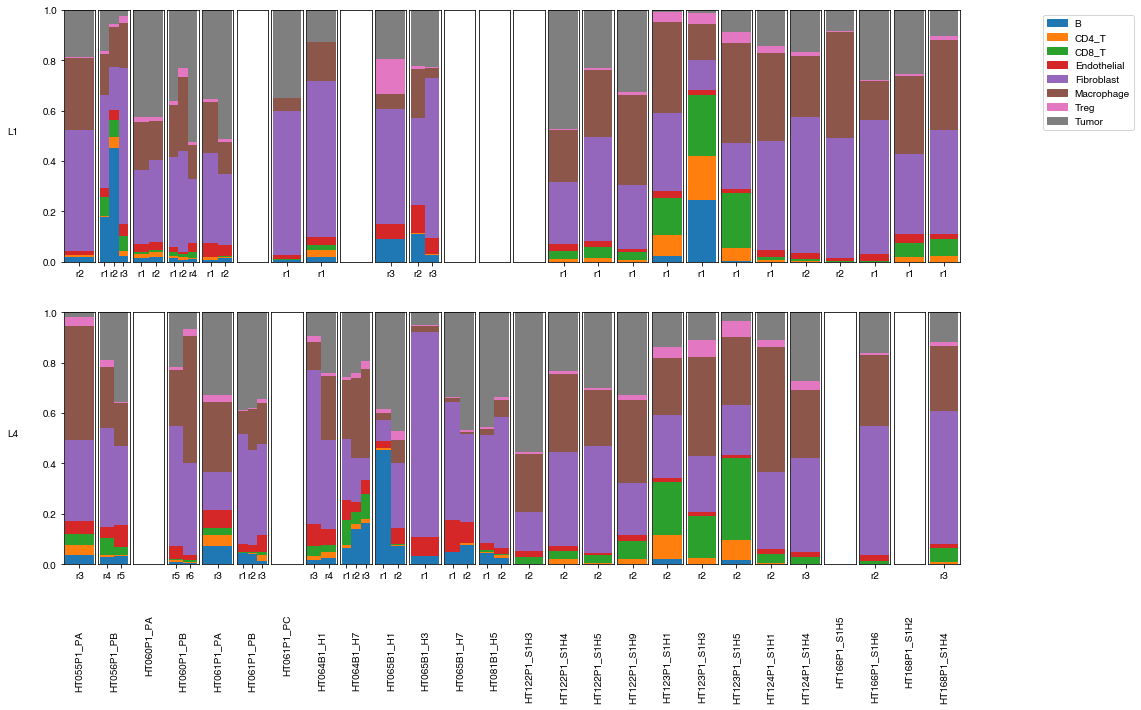

In [87]:
p_adata = adata[~pd.isnull(adata.obs['roi_location'])]
p_adata = p_adata[p_adata.obs['cell_type']!='unknown']
fractions = True

p_adata.obs['roi'] = [f'r{x}' for x in p_adata.obs['roi']]
sample_order = sorted(set(p_adata.obs['sample_id']))
roi_order = sorted(set(p_adata.obs['roi']))
location_order = sorted(set(p_adata.obs['roi_location']))
cell_types = sorted(set(p_adata.obs['cell_type']))
ylim = (0, max(Counter(p_adata.obs['image_id']).values()) + 500) if not fractions else (0, 1)


fig, axs = plt.subplots(len(location_order), len(sample_order), sharey=False,
        figsize=(15, 8), gridspec_kw={'hspace': 0.2, 'wspace': .1})

patches = [mpatches.Patch(color=sns.color_palette()[i], label=c)
                      for i, c in enumerate(cell_types)]
for i, sample in enumerate(sample_order):
    filtered = p_adata[p_adata.obs['sample_id']==sample]

    for j, location in enumerate(location_order):
        f = filtered[filtered.obs['roi_location']==location]
        rois = sorted(set(f.obs['roi']))
        ax = axs[j, i]
        plot_stacked_bar(f.obs, 'roi', 'cell_type', ax=ax, hue_order=cell_types, x_order=rois, b_width=1,
                        fractions=fractions)
        ax.set_ylim(ylim)
        ax.set_xticks(rois)
        ax.grid(False)
        
        if i != 0:
            ax.set_yticks([])
        if j == len(location_order) - 1:
            ax.set_xlabel(sample, rotation=90, labelpad=50)
        if i == 0:
            ax.set_ylabel(location, rotation=0, labelpad=30)

fig.add_subplot(111, frameon=False)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1.))
plt.yticks([])
plt.xticks([])
plt.grid(b=None)

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f'cell_types_per_roi_location.pdf'),
           bbox_inches = "tight")

###### export data

In [ ]:
adata.obs[['image_id', 'PanKeratin']].groupby('image_id').sum()

In [ ]:
## add intensity back in
df = pd.DataFrame(data=adata.raw.X, columns=adata.var.index, index=adata.obs.index)
adata.obs = pd.merge(adata.obs, df, left_index=True, right_index=True)
adata.obs

In [ ]:
adata.obs.to_csv('/Users/erikstorrs/Downloads/pdac_halo_cell_types.tsv', sep='\t',
                index=True, header=True)

In [ ]:
adata.obs

In [ ]:
# adata.obs = adata.obs[[c for c in adata.obs.columns if '_y' != c[-2:]]]
# adata.obs.columns = [c[:-2] if '_x' == c[-2:] else c for c in adata.obs.columns]
# adata.obs = adata.obs[[c for c in adata.obs.columns if '_y' != c[-2:]]]
# ls = ['nearest_b_cell',
#  'nearest_b_cell_distance',
#  'nearest_caf',
#  'nearest_caf_distance',
#  'nearest_cd4_t_cell',
#  'nearest_cd4_t_cell_distance',
#  'nearest_cd8_t_cell',
#  'nearest_cd8_t_cell_distance',
#  'nearest_endothelial',
#  'nearest_endothelial_distance',
#  'nearest_lag3+',
#  'nearest_lag3+_distance',
#  'nearest_monocyte/macrophage',
#  'nearest_monocyte/macrophage_distance',
#  'nearest_monocyte/macrophage_ki67+',
#  'nearest_monocyte/macrophage_ki67+_distance',
#  'nearest_pd1+',
#  'nearest_pd1+_distance',
#  'nearest_treg',
#  'nearest_treg_distance',
#  'nearest_tumor',
#  'nearest_tumor_distance',
#  'nearest_tumor_ki67+',
#  'nearest_tumor_ki67+_distance',
#  'nearest_tumor_pdl1+',
#  'nearest_tumor_pdl1+_distance',
#  'nearest_unknown_x',
#  'nearest_unknown_distance_x']
# adata.obs = adata.obs[[c for c in adata.obs.columns if c not in ls]]
adata.obs

In [ ]:
list(adata.obs.columns)